2025-10-16 04:49:57,641 - INFO - Load pretrained SentenceTransformer: sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2


Results directory: C:\Users\Boris\Desktop\code\multilingual-rag\results
Loading: multilingual_rag_results.csv
✓ Loaded 60 experiment results
Hindi results: 30
Chinese results: 30


2025-10-16 04:49:59,956 - INFO - Use pytorch device_name: cpu
2025-10-16 04:49:59,956 - INFO - Using default tokenizer.


✓ Initialized enhanced evaluator with model: sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2

ENHANCED HINDI EVALUATION

Evaluating 30 Hindi questions...

[1/30] इंसुलिन प्रतिरोध क्या है और यह कोशिकाओं में ग्लूको...
  Semantic similarity: 1.000
  ROUGE-L: 0.869
  Time speedup: 0.97x

[2/30] हृदय रोग के जोखिम पर पारिवारिक इतिहास का क्या प्रभ...
  Semantic similarity: 0.990
  ROUGE-L: 0.788
  Time speedup: 0.84x

[3/30] धूम्रपान का रक्तचाप और हृदय रोग के जोखिम पर क्या प...
  Semantic similarity: 0.912
  ROUGE-L: 0.548
  Time speedup: 0.87x

[4/30] हृदय रोग के कौन से जोखिम कारक बदले जा सकते हैं?...
  Semantic similarity: 0.969
  ROUGE-L: 0.774
  Time speedup: 0.73x

[5/30] विभिन्न जातीय समूहों में हृदय रोग की दरों में क्या...
  Semantic similarity: 0.975
  ROUGE-L: 0.759
  Time speedup: 0.81x

[6/30] शराब के सेवन का हृदय रोग के जोखिम पर क्या प्रभाव प...
  Semantic similarity: 0.936
  ROUGE-L: 0.545
  Time speedup: 0.61x

[7/30] अतिरिक्त कैलोरी का हृदय रोग के जोखिम पर क्या प्रभ

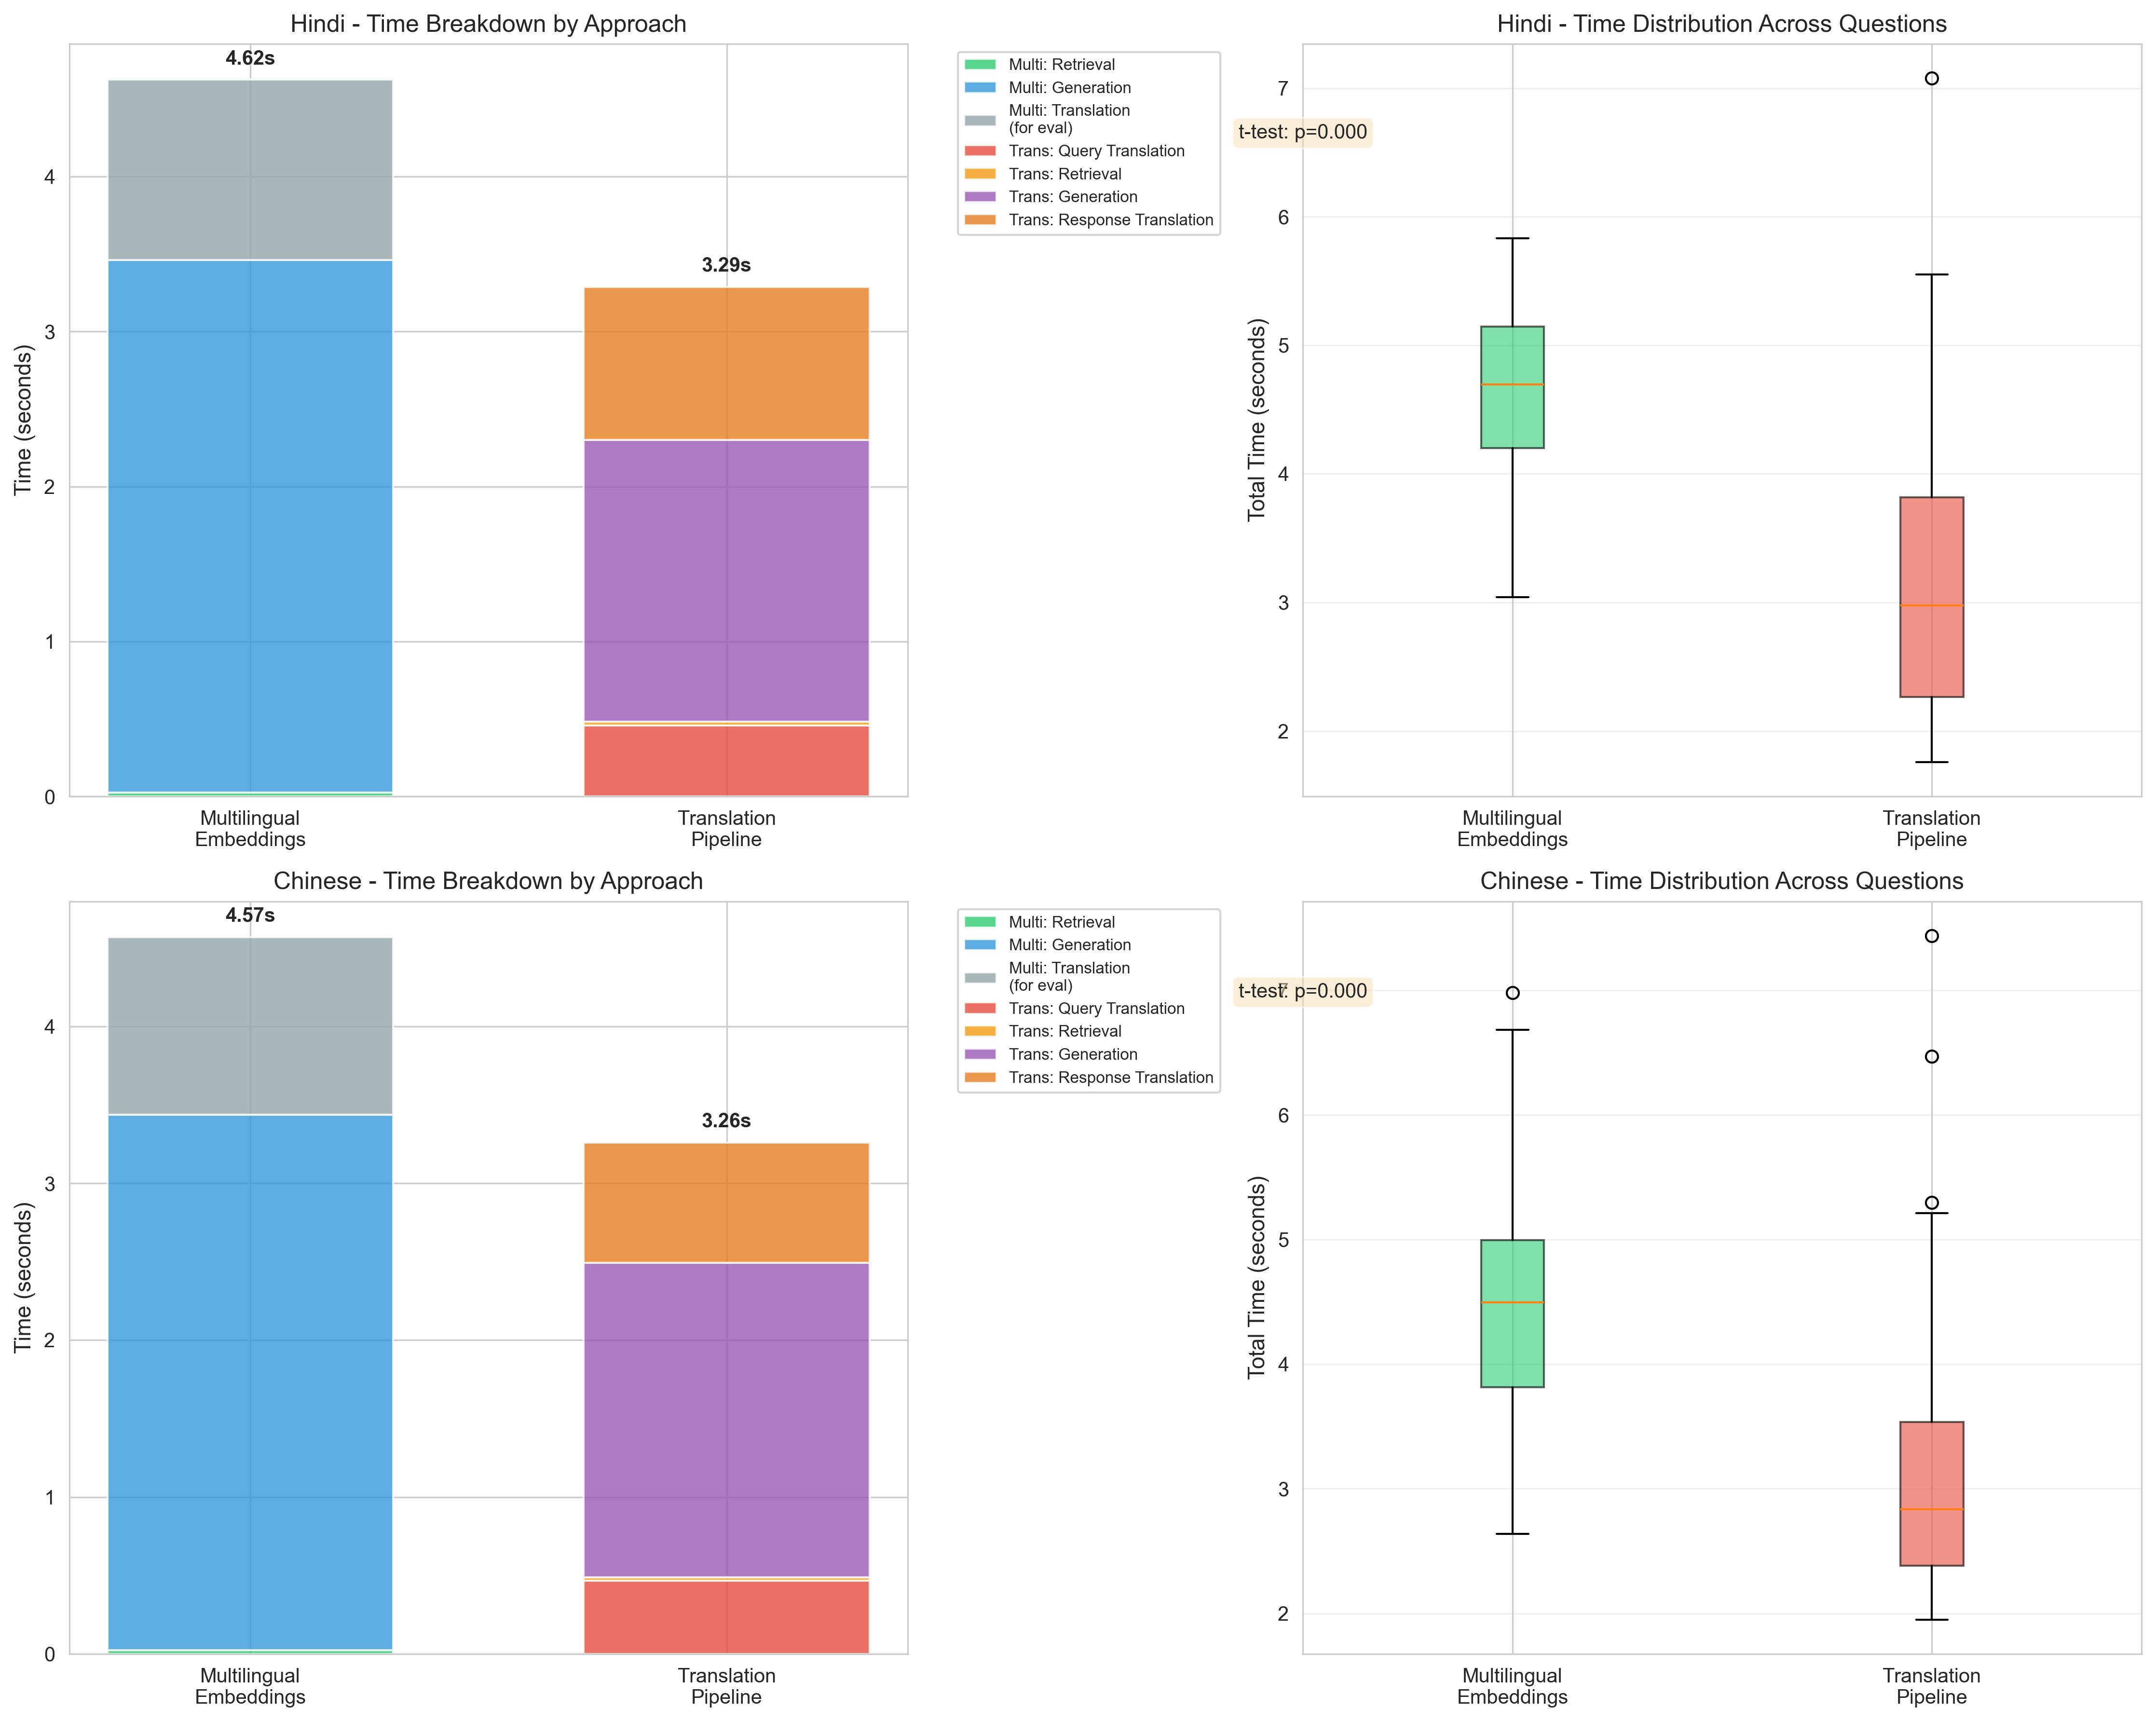


2. Quality Metrics Analysis (Per Language)...
✓ Saved quality metrics to C:\Users\Boris\Desktop\code\multilingual-rag\results\enhanced_figures\quality_metrics_per_language.png


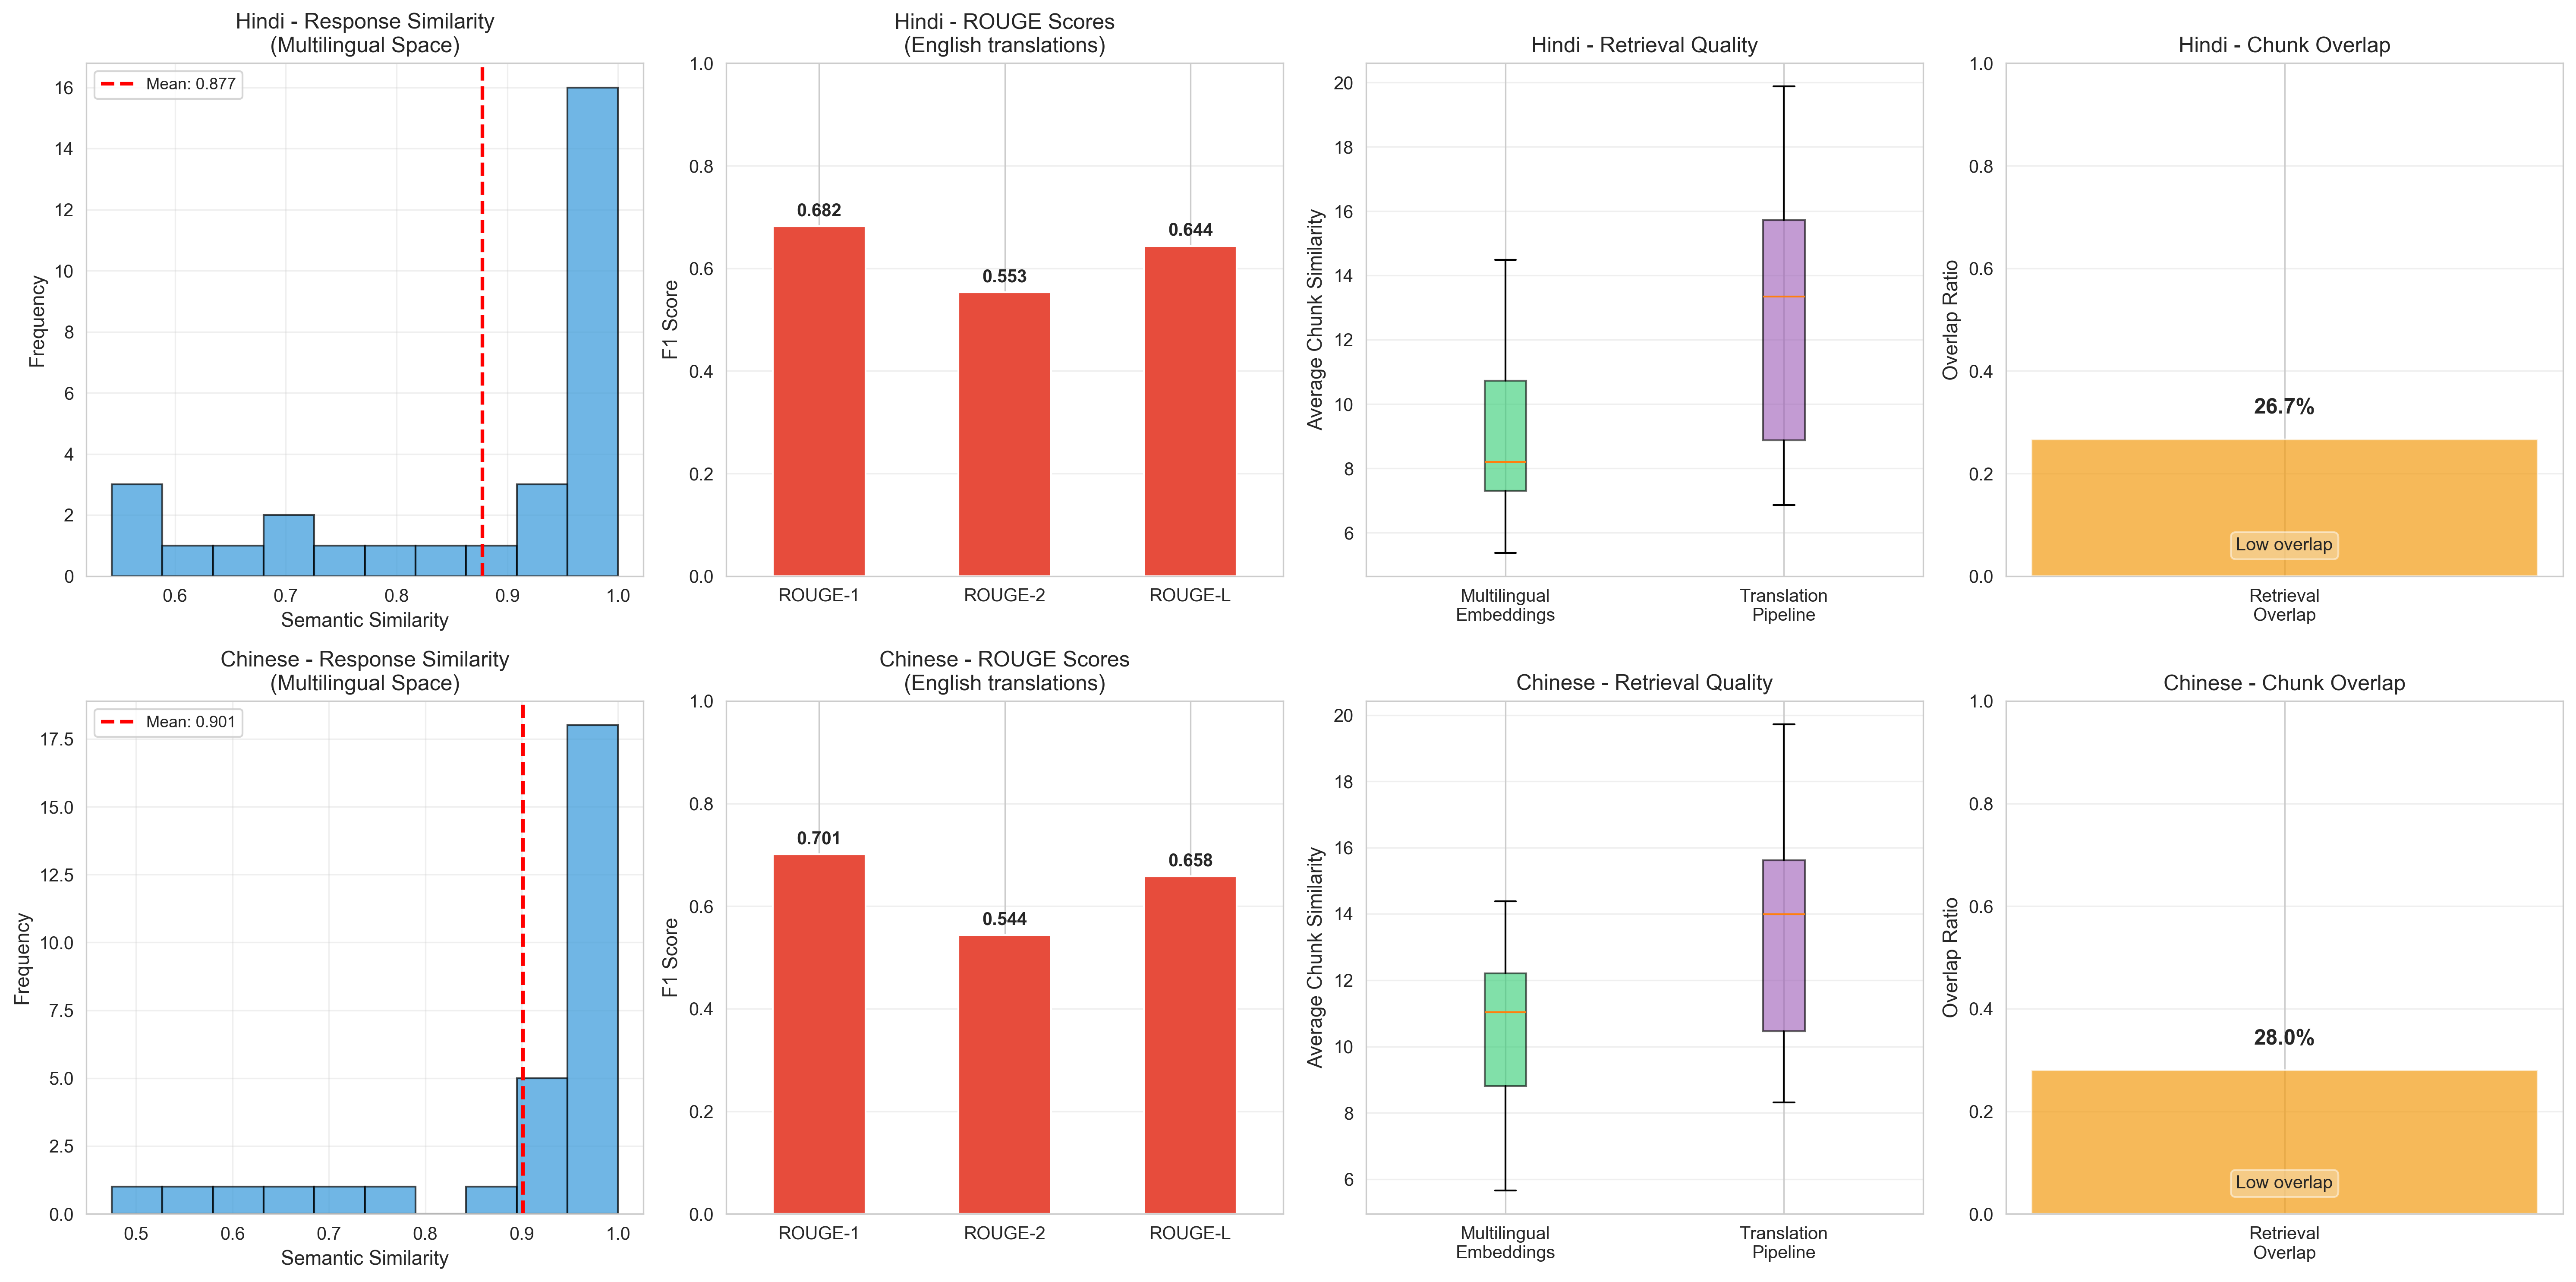


3. Cross-Language Comparison...
✓ Saved cross-language comparison to C:\Users\Boris\Desktop\code\multilingual-rag\results\enhanced_figures\cross_language_comparison.png


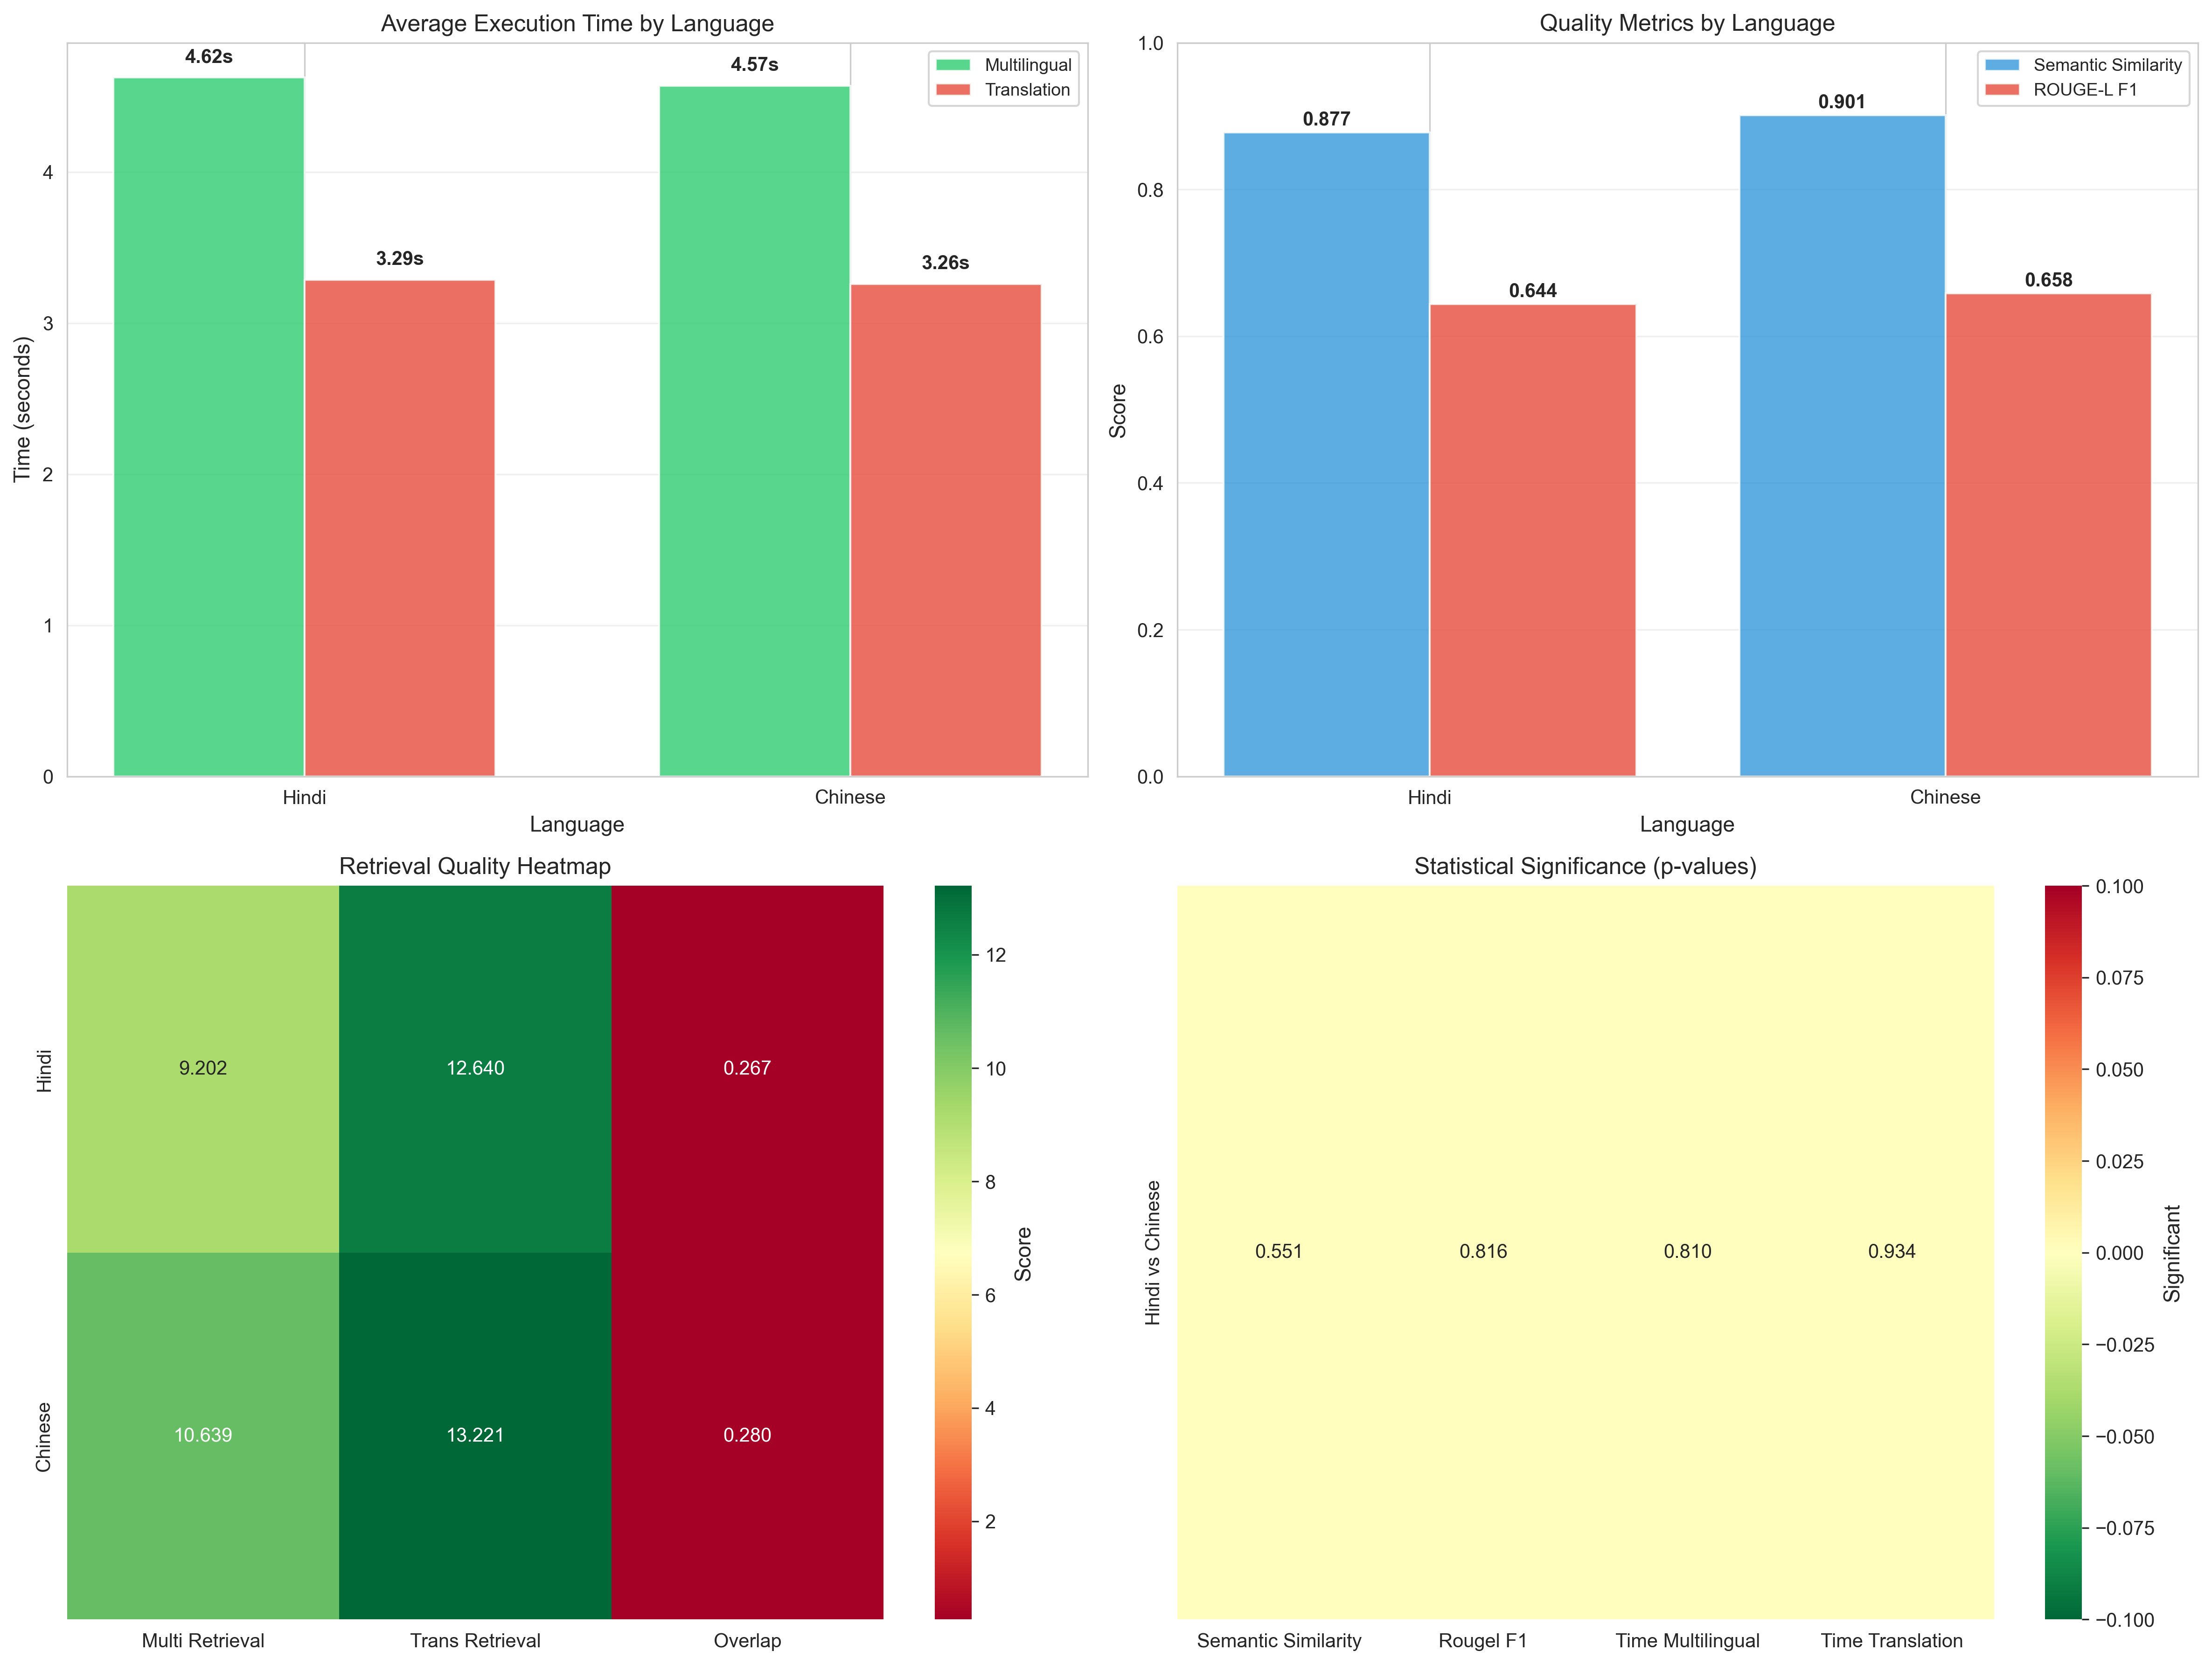


4. Deep Chunk Overlap Analysis...
✓ Saved chunk overlap analysis to C:\Users\Boris\Desktop\code\multilingual-rag\results\enhanced_figures\chunk_overlap_analysis.png


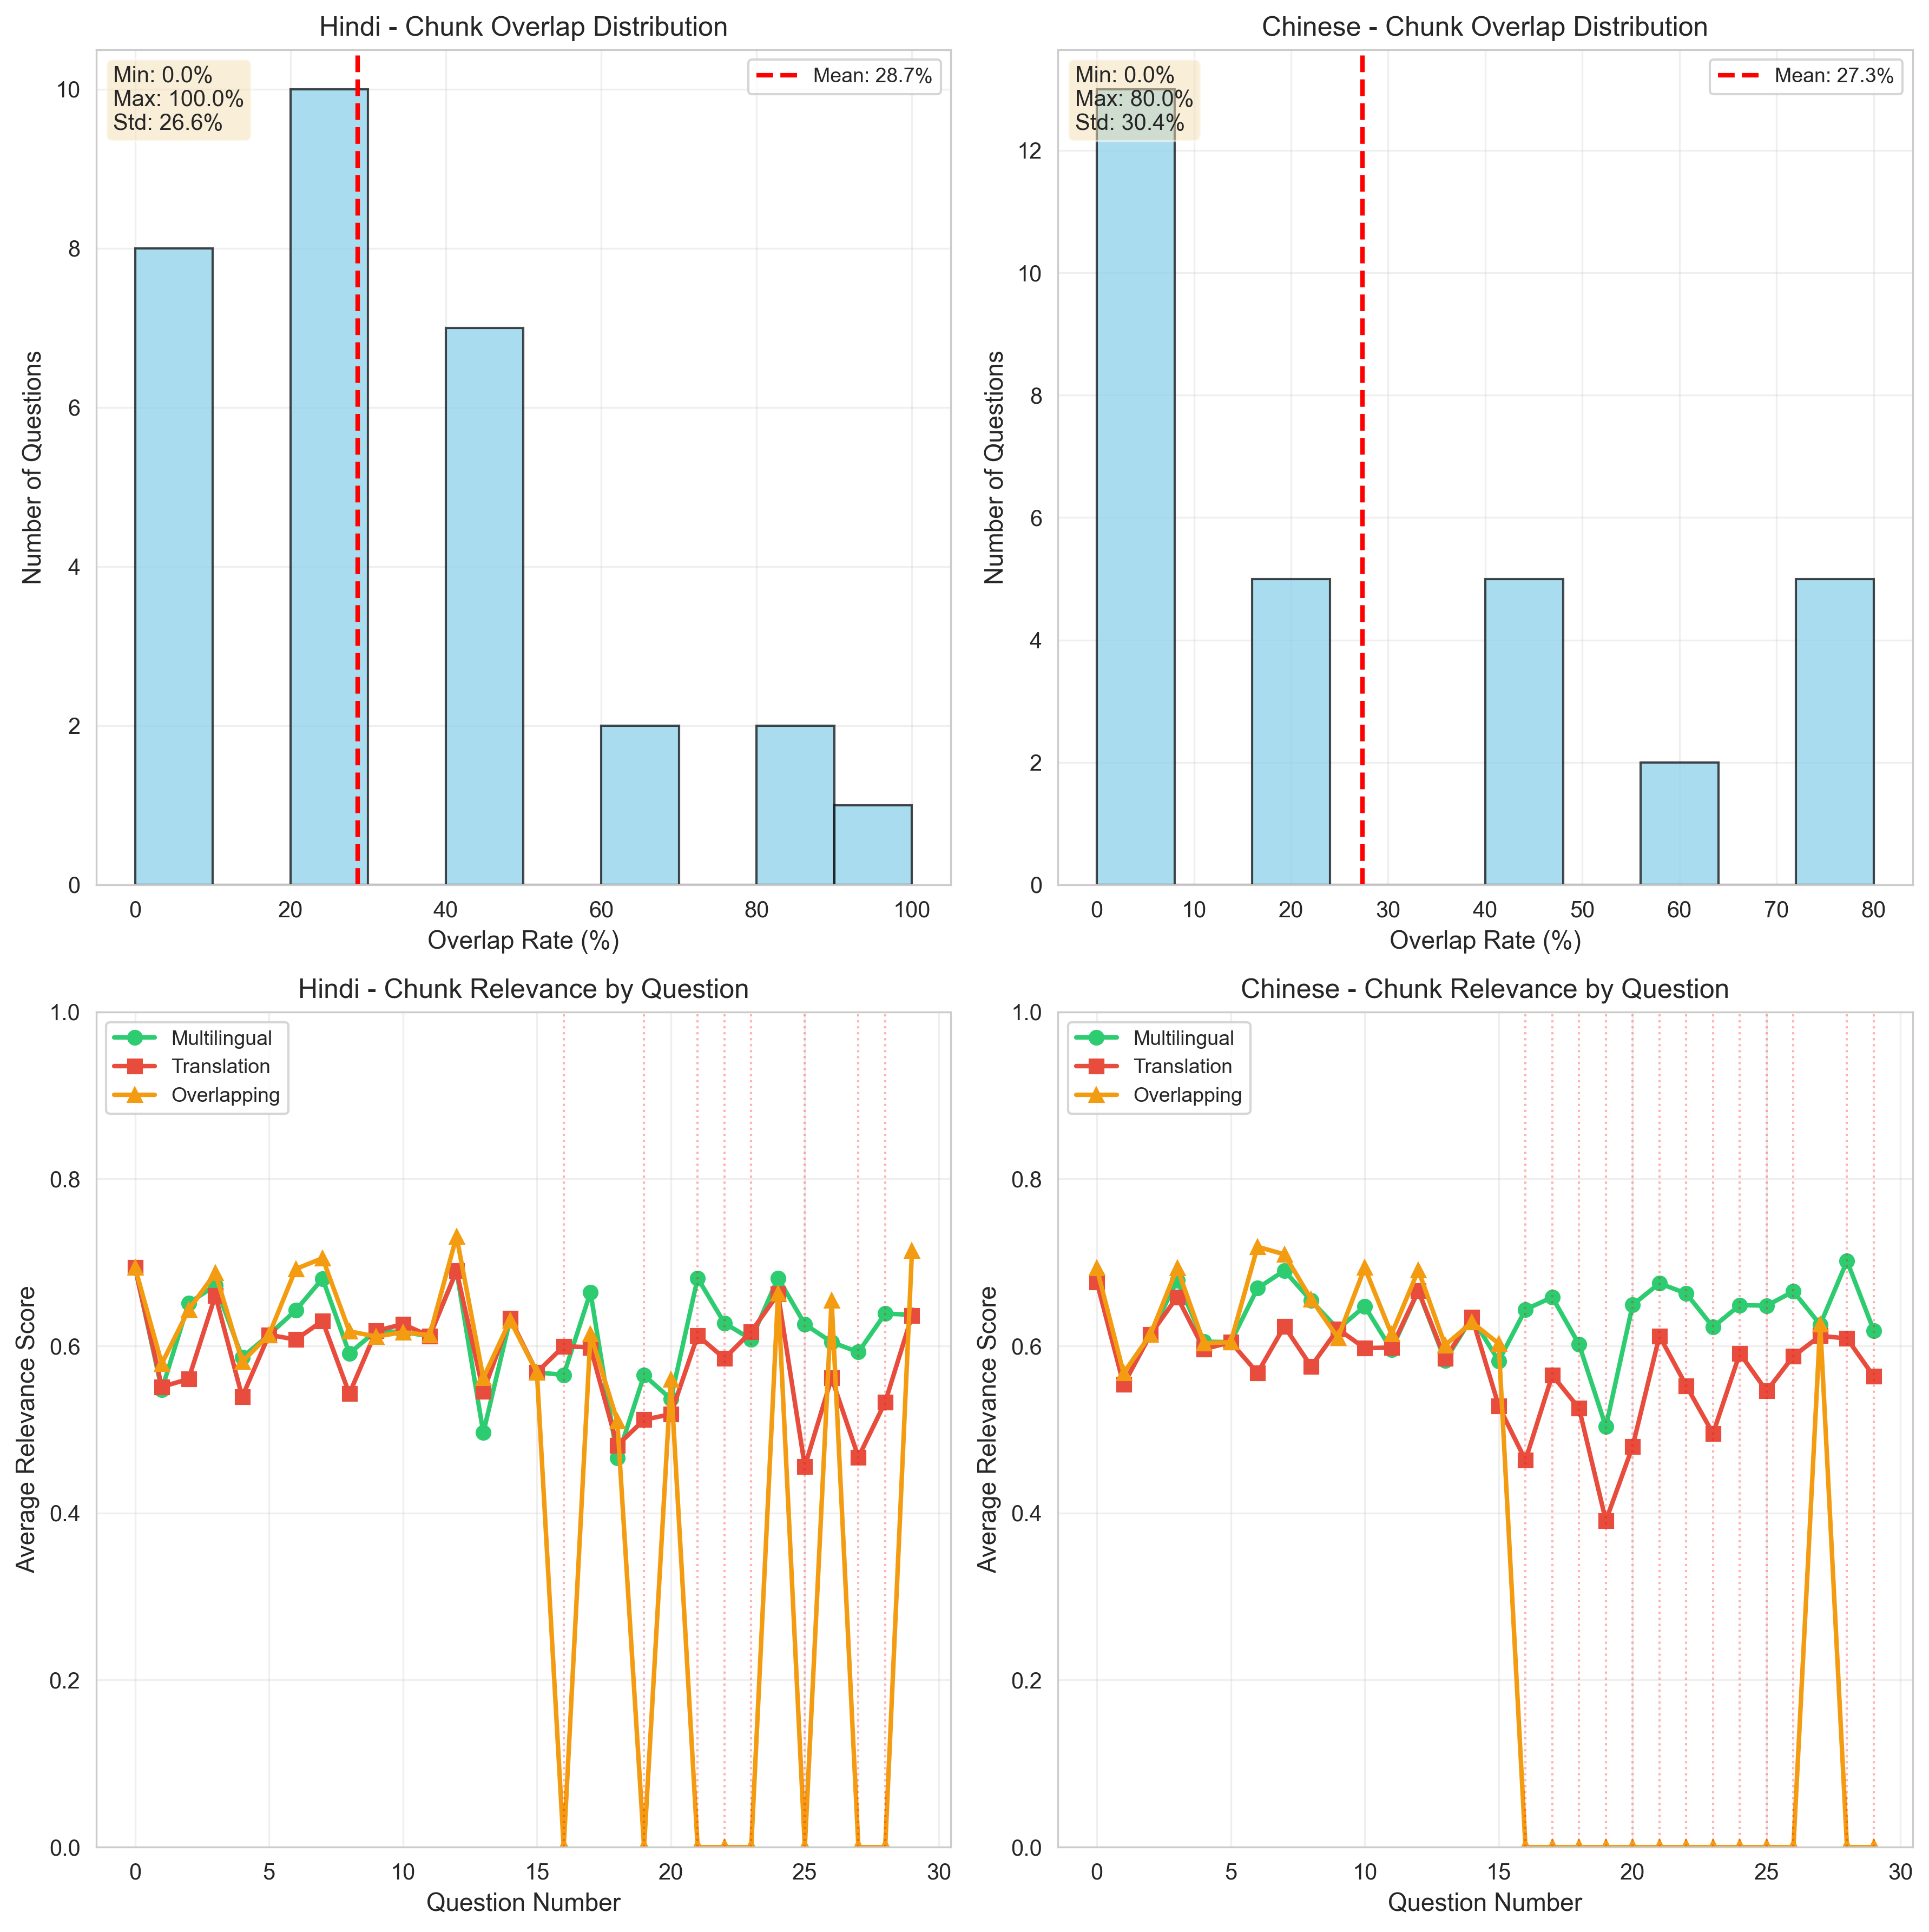


5. Statistical Report...

COMPREHENSIVE STATISTICAL REPORT
Language                 Metric            Multilingual             Translation P-value      Winner
   Hindi Average Total Time (s)           4.624 ± 0.752           3.287 ± 1.248 0.0000* Translation
   Hindi    Semantic Similarity N/A (comparison metric) N/A (comparison metric)     N/A Mean: 0.877
   Hindi    Avg Retrieval Score           9.202 ± 2.535          12.640 ± 3.637 0.0000* Translation
 Chinese Average Total Time (s)           4.569 ± 1.004           3.260 ± 1.296 0.0000* Translation
 Chinese    Semantic Similarity N/A (comparison metric) N/A (comparison metric)     N/A Mean: 0.901
 Chinese    Avg Retrieval Score          10.639 ± 2.389          13.221 ± 3.140 0.0000* Translation


✓ Saved statistical report to C:\Users\Boris\Desktop\code\multilingual-rag\results\enhanced_figures\enhanced_statistical_report.csv

✓ All enhanced visualizations saved to C:\Users\Boris\Desktop\code\multilingual-rag\results\enhanced_figu

In [2]:
# Notebook 4: Enhanced Multilingual RAG Evaluation and Analysis - Hindi + Chinese
# Combines cross-language analysis with deep per-language evaluation

import sys
import os
sys.path.append('..')

import json
import pandas as pd
import numpy as np
from pathlib import Path
from datetime import datetime
from typing import Dict, List, Tuple
import logging

import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore', category=UserWarning, module='matplotlib')
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=UserWarning, module='transformers')

# Suppress sentence transformers progress bars
import os
os.environ['TOKENIZERS_PARALLELISM'] = 'false'

from rouge_score import rouge_scorer
from sklearn.metrics.pairwise import cosine_similarity
from sentence_transformers import SentenceTransformer
from scipy import stats

import nltk
nltk.download('punkt', quiet=True)
nltk.download('wordnet', quiet=True)
nltk.download('omw-1.4', quiet=True)

logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s'
)

ROOT_DIR = Path('..').resolve()
RESULTS_DIR = ROOT_DIR / 'results'

print(f"Results directory: {RESULTS_DIR}")

sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['figure.dpi'] = 300
plt.rcParams['font.size'] = 10

# ============================================================================
# Load and Prepare Data
# ============================================================================

results_file = RESULTS_DIR / 'multilingual_rag_results.csv'

if not results_file.exists():
    print("❌ No experiment results found. Please run notebook 3 first.")
    raise FileNotFoundError("multilingual_rag_results.csv not found")
else:
    print(f"Loading: {results_file.name}")
    
    df_results = pd.read_csv(results_file, encoding='utf-8')
    print(f"✓ Loaded {len(df_results)} experiment results")

# Split by language
df_hindi = df_results[df_results['language'] == 'Hindi'].copy()
df_chinese = df_results[df_results['language'] == 'Chinese'].copy()

print(f"Hindi results: {len(df_hindi)}")
print(f"Chinese results: {len(df_chinese)}")

# ============================================================================
# Enhanced Multilingual RAG Evaluator Class
# ============================================================================

class EnhancedMultilingualRAGEvaluator:
    """
    Enhanced evaluation for cross-lingual RAG systems with deep analysis.
    
    Key innovation: Evaluate in multilingual semantic space to avoid 
    double-translation bias, with comprehensive component analysis.
    """
    
    def __init__(self, multilingual_model: str = 'sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2'):
        # For semantic similarity in multilingual space
        self.multilingual_encoder = SentenceTransformer(multilingual_model)
        
        # Disable progress bars to clean up output
        self.multilingual_encoder.encode = self._encode_without_progress
        
        # For ROUGE (works on token level)
        self.rouge_scorer_obj = rouge_scorer.RougeScorer(
            ['rouge1', 'rouge2', 'rougeL'], use_stemmer=True
        )
        
        print(f"✓ Initialized enhanced evaluator with model: {multilingual_model}")
    
    def _encode_without_progress(self, sentences, **kwargs):
        """Wrapper to disable progress bars during encoding"""
        # Disable progress bar for cleaner output
        kwargs['show_progress_bar'] = False
        return SentenceTransformer.encode(self.multilingual_encoder, sentences, **kwargs)
    
    def calculate_multilingual_semantic_similarity(self, text1: str, text2: str) -> float:
        """Calculate semantic similarity between two texts in ANY language."""
        embeddings = self.multilingual_encoder.encode([text1, text2])
        similarity = cosine_similarity([embeddings[0]], [embeddings[1]])[0][0]
        return float(similarity)
    
    def calculate_rouge_on_translated(self, text1_english: str, text2_english: str) -> Dict[str, float]:
        """Calculate ROUGE scores on English translations."""
        scores = self.rouge_scorer_obj.score(text1_english, text2_english)
        return {
            'rouge1_f1': scores['rouge1'].fmeasure,
            'rouge1_precision': scores['rouge1'].precision,
            'rouge1_recall': scores['rouge1'].recall,
            'rouge2_f1': scores['rouge2'].fmeasure,
            'rouge2_precision': scores['rouge2'].precision,
            'rouge2_recall': scores['rouge2'].recall,
            'rougeL_f1': scores['rougeL'].fmeasure,
            'rougeL_precision': scores['rougeL'].precision,
            'rougeL_recall': scores['rougeL'].recall,
        }
    
    def _parse_list(self, data):
        """Parse list from string, handling both strings and actual lists"""
        if isinstance(data, str):
            try:
                return eval(data)
            except:
                return []
        elif isinstance(data, list):
            return data
        else:
            return []
    
    def evaluate_retrieval_quality(self, chunk_scores_1: List[float], chunk_scores_2: List[float],
                                   sources_1: List[str], sources_2: List[str]) -> Dict[str, float]:
        """Compare retrieval quality between two approaches"""
        result = {}
        
        # Parse and convert to numeric
        chunk_scores_1 = self._parse_list(chunk_scores_1)
        chunk_scores_2 = self._parse_list(chunk_scores_2)
        sources_1 = self._parse_list(sources_1)
        sources_2 = self._parse_list(sources_2)
        
        # Convert to float if needed
        try:
            chunk_scores_1 = [float(x) for x in chunk_scores_1 if x]
        except:
            chunk_scores_1 = []
        
        try:
            chunk_scores_2 = [float(x) for x in chunk_scores_2 if x]
        except:
            chunk_scores_2 = []
        
        # Average similarity scores
        if chunk_scores_1:
            result['avg_similarity_score_1'] = np.mean(chunk_scores_1)
            result['min_similarity_score_1'] = np.min(chunk_scores_1)
        else:
            result['avg_similarity_score_1'] = 0.0
            result['min_similarity_score_1'] = 0.0
        
        if chunk_scores_2:
            result['avg_similarity_score_2'] = np.mean(chunk_scores_2)
            result['min_similarity_score_2'] = np.min(chunk_scores_2)
        else:
            result['avg_similarity_score_2'] = 0.0
            result['min_similarity_score_2'] = 0.0
        
        # Source diversity
        result['unique_sources_1'] = len(set(sources_1)) if sources_1 else 0
        result['unique_sources_2'] = len(set(sources_2)) if sources_2 else 0
        
        # Overlap in retrieved chunks (by source)
        if sources_1 and sources_2:
            overlap = len(set(sources_1) & set(sources_2))
            result['retrieval_overlap'] = overlap / max(len(sources_1), len(sources_2))
        else:
            result['retrieval_overlap'] = 0.0
        
        return result
    
    def evaluate_single_question(self, row: pd.Series, language: str) -> Dict[str, float]:
        """Evaluate a single question across both approaches"""
        results = {}
        
        # Get responses in native language (what user sees)
        response_multi = str(row.get('multilingual_response', ''))
        response_trans = str(row.get('translation_response', ''))
        
        # Get responses in English (for evaluation)
        response_multi_en = str(row.get('multilingual_response_english_for_eval', ''))
        response_trans_en = str(row.get('translation_response_english_for_eval', ''))
        
        # ===== Response Quality Evaluation =====
        
        # 1. Multilingual semantic similarity (native language - no translation bias)
        if response_multi and response_trans:
            results['semantic_similarity'] = self.calculate_multilingual_semantic_similarity(
                response_multi, response_trans
            )
        else:
            results['semantic_similarity'] = 0.0
        
        # 2. ROUGE on English translations (standard practice, but has bias)
        if response_multi_en and response_trans_en:
            rouge_scores = self.calculate_rouge_on_translated(
                response_multi_en, response_trans_en
            )
            results.update(rouge_scores)
        else:
            results.update({
                'rouge1_f1': 0.0, 'rouge2_f1': 0.0, 'rougeL_f1': 0.0,
                'rouge1_precision': 0.0, 'rouge1_recall': 0.0,
                'rouge2_precision': 0.0, 'rouge2_recall': 0.0,
                'rougeL_precision': 0.0, 'rougeL_recall': 0.0,
            })
        
        # ===== Retrieval Quality Evaluation =====
        
        chunk_scores_multi = row.get('multilingual_chunk_scores', [])
        chunk_scores_trans = row.get('translation_chunk_scores', [])
        sources_multi = row.get('multilingual_chunk_sources', [])
        sources_trans = row.get('translation_chunk_sources', [])
        
        retrieval_metrics = self.evaluate_retrieval_quality(
            chunk_scores_multi, chunk_scores_trans, sources_multi, sources_trans
        )
        
        # Rename for clarity
        for key, value in retrieval_metrics.items():
            if '_1' in key:
                new_key = key.replace('_1', '_multilingual')
            elif '_2' in key:
                new_key = key.replace('_2', '_translation')
            else:
                new_key = key
            results[new_key] = value
        
        # ===== Time/Efficiency Metrics =====
        
        results['time_multilingual'] = row.get('multilingual_total_time', 0.0)
        results['time_translation'] = row.get('translation_total_time', 0.0)
        results['time_difference'] = results['time_translation'] - results['time_multilingual']
        results['time_speedup'] = (
            results['time_translation'] / results['time_multilingual'] 
            if results['time_multilingual'] > 0 else 0.0
        )
        
        # Enhanced time component analysis
        results['multilingual_retrieval_time'] = row.get('multilingual_retrieval_time', 0.0)
        results['multilingual_generation_time'] = row.get('multilingual_generation_time', 0.0)
        results['multilingual_response_translation_time'] = row.get('multilingual_response_translation_time', 0.0)
        results['translation_question_translation_time'] = row.get('translation_question_translation_time', 0.0)
        results['translation_retrieval_time'] = row.get('translation_retrieval_time', 0.0)
        results['translation_generation_time'] = row.get('translation_generation_time', 0.0)
        results['translation_response_translation_time'] = row.get('translation_response_translation_time', 0.0)
        
        results['language'] = language
        
        return results
    
    def evaluate_dataset(self, df_results: pd.DataFrame, language: str, output_path: str = None) -> pd.DataFrame:
        """Evaluate entire dataset of results with enhanced metrics"""
        evaluation_results = []
        
        print(f"\nEvaluating {len(df_results)} {language} questions...")
        print("=" * 80)
        
        for idx, row in df_results.iterrows():
            print(f"\n[{idx+1}/{len(df_results)}] {row['question'][:50]}...")
            
            eval_result = {
                'question_id': row['question_id'],
                'language': language,
                'question': row['question'],
                'question_english_reference': row.get('question_english_reference', ''),
            }
            
            # Run evaluation
            metrics = self.evaluate_single_question(row, language)
            eval_result.update(metrics)
            
            # Display key metrics
            print(f"  Semantic similarity: {metrics['semantic_similarity']:.3f}")
            print(f"  ROUGE-L: {metrics['rougeL_f1']:.3f}")
            print(f"  Time speedup: {metrics['time_speedup']:.2f}x")
            
            evaluation_results.append(eval_result)
        
        df_eval = pd.DataFrame(evaluation_results)
        
        # Save if path provided
        if output_path:
            Path(output_path).parent.mkdir(parents=True, exist_ok=True)
            df_eval.to_csv(output_path, index=False, encoding='utf-8')
            print(f"\n✓ Saved {language} evaluation to {output_path}")
        
        # Print summary statistics
        self._print_summary(df_eval, language)
        
        return df_eval
    
    def _print_summary(self, df_eval: pd.DataFrame, language: str):
        """Print summary statistics"""
        print("\n" + "=" * 80)
        print(f"{language.upper()} EVALUATION SUMMARY")
        print("=" * 80)
        
        print(f"\n📊 Response Quality (Semantic Similarity - No Translation Bias):")
        print(f"  Average: {df_eval['semantic_similarity'].mean():.3f}")
        print(f"  Std Dev: {df_eval['semantic_similarity'].std():.3f}")
        print(f"  Min:     {df_eval['semantic_similarity'].min():.3f}")
        print(f"  Max:     {df_eval['semantic_similarity'].max():.3f}")
        
        print(f"\n📊 Response Quality (ROUGE-L on English translations):")
        print(f"  Average F1: {df_eval['rougeL_f1'].mean():.3f}")
        print(f"  Precision:  {df_eval['rougeL_precision'].mean():.3f}")
        print(f"  Recall:     {df_eval['rougeL_recall'].mean():.3f}")
        
        print(f"\n⏱️  Time Efficiency:")
        print(f"  Multilingual approach: {df_eval['time_multilingual'].mean():.2f}s ± {df_eval['time_multilingual'].std():.2f}s")
        print(f"  Translation approach:  {df_eval['time_translation'].mean():.2f}s ± {df_eval['time_translation'].std():.2f}s")
        print(f"  Average speedup:       {df_eval['time_speedup'].mean():.2f}x")
        
        print(f"\n🔍 Retrieval Quality:")
        print(f"  Multilingual avg score: {df_eval['avg_similarity_score_multilingual'].mean():.3f}")
        print(f"  Translation avg score:  {df_eval['avg_similarity_score_translation'].mean():.3f}")
        print(f"  Retrieval overlap:      {df_eval['retrieval_overlap'].mean():.1%}")
        
        # Enhanced recommendation logic
        print(f"\n🏆 {language.upper()} WINNER:")
        if df_eval['semantic_similarity'].mean() > 0.9:
            print("  Both approaches produce highly similar results")
            if df_eval['time_multilingual'].mean() < df_eval['time_translation'].mean():
                print("  → Multilingual embeddings RECOMMENDED (faster, similar quality)")
            else:
                print("  → Translation approach RECOMMENDED (similar time, potentially better retrieval)")
        elif df_eval['semantic_similarity'].mean() > 0.7:
            print("  Approaches differ moderately - further analysis needed")
        else:
            print("  ⚠️  Significant differences detected - investigate individual cases")

# ============================================================================
# Deep Chunk Analysis Class
# ============================================================================

class DeepChunkAnalyzer:
    """
    Analyze chunk overlap and content differences between approaches.
    Critical for understanding why we get ~25% overlap and what it means.
    """
    
    def __init__(self, multilingual_encoder):
        self.multilingual_encoder = multilingual_encoder
        
        # Disable progress bars for chunk analysis
        if hasattr(multilingual_encoder, 'encode'):
            self.multilingual_encoder.encode = self._encode_without_progress
    
    def _encode_without_progress(self, sentences, **kwargs):
        """Wrapper to disable progress bars during encoding"""
        # Disable progress bar for cleaner output
        kwargs['show_progress_bar'] = False
        return SentenceTransformer.encode(self.multilingual_encoder, sentences, **kwargs)
    
    def analyze_chunks_for_question(
        self, 
        question_id: str,
        question: str,
        multi_chunks: List[str],
        trans_chunks: List[str],
        multi_sources: List[str],
        trans_sources: List[str],
        multi_scores: List[float],
        trans_scores: List[float]
    ) -> Dict[str, Any]:
        """Deep analysis of chunks for a single question"""
        
        # Convert to sets for overlap analysis
        multi_set = set(multi_chunks) if multi_chunks else set()
        trans_set = set(trans_chunks) if trans_chunks else set()
        
        # Calculate overlap
        overlapping_chunks = multi_set & trans_set
        multi_only = multi_set - trans_set
        trans_only = trans_set - multi_set
        
        overlap_count = len(overlapping_chunks)
        total_unique = len(multi_set | trans_set)
        overlap_rate = overlap_count / max(len(multi_chunks), len(trans_chunks)) if multi_chunks and trans_chunks else 0.0
        
        # Semantic analysis of chunks
        def calculate_chunk_relevance(chunk: str, question: str) -> float:
            """Calculate how relevant a chunk is to the question"""
            try:
                embeddings = self.multilingual_encoder.encode([chunk, question])
                similarity = cosine_similarity([embeddings[0]], [embeddings[1]])[0][0]
                return float(similarity)
            except:
                return 0.0
        
        # Analyze chunk quality
        multi_relevance = [calculate_chunk_relevance(chunk, question) for chunk in multi_chunks] if multi_chunks else []
        trans_relevance = [calculate_chunk_relevance(chunk, question) for chunk in trans_chunks] if trans_chunks else []
        
        overlapping_relevance = [calculate_chunk_relevance(chunk, question) for chunk in overlapping_chunks]
        multi_only_relevance = [calculate_chunk_relevance(chunk, question) for chunk in multi_only]
        trans_only_relevance = [calculate_chunk_relevance(chunk, question) for chunk in trans_only]
        
        return {
            'question_id': question_id,
            'question': question,
            'overlap_count': overlap_count,
            'overlap_rate': overlap_rate,
            'total_unique_chunks': total_unique,
            
            # Chunk counts
            'multi_chunk_count': len(multi_chunks) if multi_chunks else 0,
            'trans_chunk_count': len(trans_chunks) if trans_chunks else 0,
            'multi_only_count': len(multi_only),
            'trans_only_count': len(trans_only),
            
            # Chunk content
            'overlapping_chunks': list(overlapping_chunks),
            'multi_only_chunks': list(multi_only),
            'trans_only_chunks': list(trans_only),
            
            # Sources
            'multi_sources': multi_sources or [],
            'trans_sources': trans_sources or [],
            
            # Retrieval scores
            'multi_scores': multi_scores or [],
            'trans_scores': trans_scores or [],
            
            # Relevance analysis
            'multi_avg_relevance': np.mean(multi_relevance) if multi_relevance else 0.0,
            'trans_avg_relevance': np.mean(trans_relevance) if trans_relevance else 0.0,
            'overlapping_avg_relevance': np.mean(overlapping_relevance) if overlapping_relevance else 0.0,
            'multi_only_avg_relevance': np.mean(multi_only_relevance) if multi_only_relevance else 0.0,
            'trans_only_avg_relevance': np.mean(trans_only_relevance) if trans_only_relevance else 0.0,
            
            # Quality metrics
            'multi_best_chunk_relevance': max(multi_relevance) if multi_relevance else 0.0,
            'trans_best_chunk_relevance': max(trans_relevance) if trans_relevance else 0.0,
        }
    
    def analyze_all_chunks(
        self, 
        df_results: pd.DataFrame, 
        df_evaluation: pd.DataFrame,
        language: str
    ) -> pd.DataFrame:
        """Analyze chunks for all questions in a language"""
        
        chunk_analyses = []
        
        print(f"\n{'='*80}")
        print(f"DEEP CHUNK ANALYSIS - {language.upper()}")
        print(f"{'='*80}")
        
        for idx, row in df_results.iterrows():
            question_id = row['question_id']
            question = row['question']
            
            # Parse chunk data
            multi_chunks = self._parse_list(row.get('multilingual_retrieved_chunks', []))
            trans_chunks = self._parse_list(row.get('translation_retrieved_chunks', []))
            multi_sources = self._parse_list(row.get('multilingual_chunk_sources', []))
            trans_sources = self._parse_list(row.get('translation_chunk_sources', []))
            multi_scores = self._parse_list(row.get('multilingual_chunk_scores', []))
            trans_scores = self._parse_list(row.get('translation_chunk_scores', []))
            
            analysis = self.analyze_chunks_for_question(
                question_id=question_id,
                question=question,
                multi_chunks=multi_chunks,
                trans_chunks=trans_chunks,
                multi_sources=multi_sources,
                trans_sources=trans_sources,
                multi_scores=multi_scores,
                trans_scores=trans_scores
            )
            
            chunk_analyses.append(analysis)
            
            # Print detailed analysis for each question
            print(f"\n{'-'*60}")
            print(f"Question {idx+1}: {question[:50]}...")
            print(f"Question ID: {question_id}")
            print(f"{'-'*60}")
            
            print(f"\n📊 OVERLAP SUMMARY:")
            print(f"  Overlap: {analysis['overlap_count']}/{max(analysis['multi_chunk_count'], analysis['trans_chunk_count'])} = {analysis['overlap_rate']:.1%}")
            print(f"  Multilingual chunks: {analysis['multi_chunk_count']}")
            print(f"  Translation chunks: {analysis['trans_chunk_count']}")
            print(f"  Multilingual-only: {analysis['multi_only_count']}")
            print(f"  Translation-only: {analysis['trans_only_count']}")
            
            print(f"\n🎯 RELEVANCE SCORES:")
            print(f"  Multilingual avg relevance: {analysis['multi_avg_relevance']:.3f}")
            print(f"  Translation avg relevance: {analysis['trans_avg_relevance']:.3f}")
            print(f"  Overlapping chunks relevance: {analysis['overlapping_avg_relevance']:.3f}")
            print(f"  Multilingual-only relevance: {analysis['multi_only_avg_relevance']:.3f}")
            print(f"  Translation-only relevance: {analysis['trans_only_avg_relevance']:.3f}")
            
            # Show overlapping chunks
            if analysis['overlapping_chunks']:
                print(f"\n🔄 OVERLAPPING CHUNKS ({len(analysis['overlapping_chunks'])}):")
                for i, chunk in enumerate(analysis['overlapping_chunks'][:2], 1):  # Show first 2
                    print(f"  [{i}] {chunk[:150]}...")
            
            # Show unique chunks
            if analysis['multi_only_chunks']:
                print(f"\n🔵 MULTILINGUAL-ONLY CHUNKS ({len(analysis['multi_only_chunks'])}):")
                for i, chunk in enumerate(analysis['multi_only_chunks'][:2], 1):  # Show first 2
                    print(f"  [{i}] {chunk[:150]}...")
            
            if analysis['trans_only_chunks']:
                print(f"\n🔴 TRANSLATION-ONLY CHUNKS ({len(analysis['trans_only_chunks'])}):")
                for i, chunk in enumerate(analysis['trans_only_chunks'][:2], 1):  # Show first 2
                    print(f"  [{i}] {chunk[:150]}...")
            
            # Quality assessment
            multi_better = analysis['multi_avg_relevance'] > analysis['trans_avg_relevance']
            winner = "Multilingual" if multi_better else "Translation"
            diff = abs(analysis['multi_avg_relevance'] - analysis['trans_avg_relevance'])
            
            print(f"\n🏆 QUALITY WINNER: {winner} (difference: {diff:.3f})")
        
        return pd.DataFrame(chunk_analyses)
    
    def _parse_list(self, data):
        """Parse list from string, handling both strings and actual lists"""
        if isinstance(data, str):
            try:
                return eval(data)
            except:
                return []
        elif isinstance(data, list):
            return data
        else:
            return []
    
    def generate_chunk_analysis_report(self, chunk_analyses: pd.DataFrame, language: str) -> Dict[str, Any]:
        """Generate summary report of chunk analysis"""
        
        print(f"\n{'='*80}")
        print(f"CHUNK ANALYSIS SUMMARY - {language.upper()}")
        print(f"{'='*80}")
        
        # Overall statistics
        total_questions = len(chunk_analyses)
        avg_overlap = chunk_analyses['overlap_rate'].mean()
        
        print(f"\n📈 OVERALL STATISTICS:")
        print(f"  Total questions: {total_questions}")
        print(f"  Average overlap rate: {avg_overlap:.1%}")
        print(f"  Questions with 0% overlap: {sum(chunk_analyses['overlap_rate'] == 0)}")
        print(f"  Questions with >50% overlap: {sum(chunk_analyses['overlap_rate'] > 0.5)}")
        
        # Relevance comparison
        multi_better_count = sum(chunk_analyses['multi_avg_relevance'] > chunk_analyses['trans_avg_relevance'])
        trans_better_count = sum(chunk_analyses['trans_avg_relevance'] > chunk_analyses['multi_avg_relevance'])
        
        print(f"\n🎯 RELEVANCE COMPARISON:")
        print(f"  Multilingual better: {multi_better_count}/{total_questions} = {multi_better_count/total_questions:.1%}")
        print(f"  Translation better: {trans_better_count}/{total_questions} = {trans_better_count/total_questions:.1%}")
        print(f"  Average multilingual relevance: {chunk_analyses['multi_avg_relevance'].mean():.3f}")
        print(f"  Average translation relevance: {chunk_analyses['trans_avg_relevance'].mean():.3f}")
        
        # Unique content analysis
        avg_multi_only = chunk_analyses['multi_only_count'].mean()
        avg_trans_only = chunk_analyses['trans_only_count'].mean()
        
        print(f"\n🔍 UNIQUE CONTENT:")
        print(f"  Avg multilingual-only chunks: {avg_multi_only:.1f}")
        print(f"  Avg translation-only chunks: {avg_trans_only:.1f}")
        print(f"  Avg multilingual-only relevance: {chunk_analyses['multi_only_avg_relevance'].mean():.3f}")
        print(f"  Avg translation-only relevance: {chunk_analyses['trans_only_avg_relevance'].mean():.3f}")
        
        # Key insights
        print(f"\n💡 KEY INSIGHTS:")
        
        if avg_overlap < 0.3:
            print(f"  ⚠️  LOW OVERLAP ({avg_overlap:.1%}) - Approaches access fundamentally different content")
        elif avg_overlap > 0.7:
            print(f"  ✅ HIGH OVERLAP ({avg_overlap:.1%}) - Approaches access similar content")
        else:
            print(f"  📊 MODERATE OVERLAP ({avg_overlap:.1%}) - Some content differences")
        
        if chunk_analyses['multi_only_avg_relevance'].mean() > chunk_analyses['trans_only_avg_relevance'].mean():
            print(f"  🔵 Multilingual-only chunks are more relevant to questions")
        else:
            print(f"  🔴 Translation-only chunks are more relevant to questions")
        
        if chunk_analyses['overlapping_avg_relevance'].mean() > max(chunk_analyses['multi_only_avg_relevance'].mean(), 
                                                                    chunk_analyses['trans_only_avg_relevance'].mean()):
            print(f"  🔄 Overlapping chunks are highest quality (both approaches agree)")
        else:
            print(f"  🎯 Unique chunks may be more valuable than overlapping ones")
        
        return {
            'language': language,
            'total_questions': total_questions,
            'avg_overlap_rate': avg_overlap,
            'multilingual_better_count': multi_better_count,
            'translation_better_count': trans_better_count,
            'avg_multi_relevance': chunk_analyses['multi_avg_relevance'].mean(),
            'avg_trans_relevance': chunk_analyses['trans_avg_relevance'].mean(),
        }

# ============================================================================
# Enhanced Visualization and Analysis Class
# ============================================================================

class EnhancedRAGVisualizationAnalysis:
    """Generate publication-ready visualizations and statistical tests for multilingual RAG"""
    
    def __init__(self, df_results_by_lang: Dict[str, pd.DataFrame], df_evaluation_by_lang: Dict[str, pd.DataFrame]):
        self.df_results_by_lang = df_results_by_lang
        self.df_eval_by_lang = df_evaluation_by_lang
        
        # Set style for publication
        sns.set_style('whitegrid')
        plt.rcParams['figure.dpi'] = 300
        plt.rcParams['font.size'] = 10
        plt.rcParams['axes.labelsize'] = 11
        plt.rcParams['axes.titlesize'] = 12
        plt.rcParams['legend.fontsize'] = 9
    
    def plot_time_comparison_per_language(self, save_path: str = None):
        """Compare execution time with component breakdown for each language"""
        n_languages = len(self.df_results_by_lang)
        fig, axes = plt.subplots(n_languages, 2, figsize=(15, 6 * n_languages))
        
        if n_languages == 1:
            axes = axes.reshape(1, -1)
        
        for lang_idx, (language, df_results) in enumerate(self.df_results_by_lang.items()):
            df_eval = self.df_eval_by_lang[language]
            
            # Extract time components
            multi_times = pd.DataFrame({
                'Retrieval': df_eval['multilingual_retrieval_time'],
                'Generation': df_eval['multilingual_generation_time'],
                'Translation\n(for eval)': df_eval['multilingual_response_translation_time']
            })
            
            trans_times = pd.DataFrame({
                'Query Translation': df_eval['translation_question_translation_time'],
                'Retrieval': df_eval['translation_retrieval_time'],
                'Generation': df_eval['translation_generation_time'],
                'Response Translation': df_eval['translation_response_translation_time']
            })
            
            # Plot 1: Stacked bar chart
            ax1 = axes[lang_idx, 0]
            multi_means = multi_times.mean()
            trans_means = trans_times.mean()
            
            x = np.arange(2)
            width = 0.6
            
            # Multilingual stack
            bottom_m = 0
            colors_m = ['#2ecc71', '#3498db', '#95a5a6']
            for idx, (component, value) in enumerate(multi_means.items()):
                ax1.bar(0, value, width, bottom=bottom_m, 
                       label=f'Multi: {component}', color=colors_m[idx], alpha=0.8)
                bottom_m += value
            
            # Translation stack
            bottom_t = 0
            colors_t = ['#e74c3c', '#f39c12', '#9b59b6', '#e67e22']
            for idx, (component, value) in enumerate(trans_means.items()):
                ax1.bar(1, value, width, bottom=bottom_t,
                       label=f'Trans: {component}', color=colors_t[idx], alpha=0.8)
                bottom_t += value
            
            ax1.set_xticks(x)
            ax1.set_xticklabels(['Multilingual\nEmbeddings', 'Translation\nPipeline'])
            ax1.set_ylabel('Time (seconds)')
            ax1.set_title(f'{language} - Time Breakdown by Approach')
            ax1.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)
            
            # Add total time annotations
            ax1.text(0, bottom_m + 0.1, f'{bottom_m:.2f}s', ha='center', fontweight='bold')
            ax1.text(1, bottom_t + 0.1, f'{bottom_t:.2f}s', ha='center', fontweight='bold')
            
            # Plot 2: Box plot for variance
            ax2 = axes[lang_idx, 1]
            total_times_data = pd.DataFrame({
                'Multilingual': df_eval['time_multilingual'],
                'Translation': df_eval['time_translation']
            })
            
            bp = ax2.boxplot([total_times_data['Multilingual'], total_times_data['Translation']],
                             labels=['Multilingual\nEmbeddings', 'Translation\nPipeline'],
                             patch_artist=True)
            
            for patch, color in zip(bp['boxes'], ['#2ecc71', '#e74c3c']):
                patch.set_facecolor(color)
                patch.set_alpha(0.6)
            
            ax2.set_ylabel('Total Time (seconds)')
            ax2.set_title(f'{language} - Time Distribution Across Questions')
            ax2.grid(axis='y', alpha=0.3)
            
            # Statistical test
            t_stat, p_value = stats.ttest_rel(
                df_eval['time_multilingual'],
                df_eval['time_translation']
            )
            
            ax2.text(0.5, ax2.get_ylim()[1] * 0.9, 
                    f't-test: p={p_value:.3f}', 
                    ha='center', transform=ax2.transData,
                    bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
        
        plt.tight_layout()
        
        if save_path:
            plt.savefig(save_path, dpi=300, bbox_inches='tight')
            print(f"✓ Saved time comparison to {save_path}")
        
        plt.show()
    
    def plot_quality_metrics_per_language(self, save_path: str = None):
        """Compare quality metrics for each language"""
        n_languages = len(self.df_eval_by_lang)
        fig, axes = plt.subplots(n_languages, 4, figsize=(20, 5 * n_languages))
        
        if n_languages == 1:
            axes = axes.reshape(1, -1)
        
        for lang_idx, (language, df_eval) in enumerate(self.df_eval_by_lang.items()):
            
            # Plot 1: Semantic similarity distribution
            ax1 = axes[lang_idx, 0]
            ax1.hist(df_eval['semantic_similarity'], bins=10, 
                    edgecolor='black', color='#3498db', alpha=0.7)
            ax1.axvline(df_eval['semantic_similarity'].mean(), 
                       color='red', linestyle='--', linewidth=2, 
                       label=f"Mean: {df_eval['semantic_similarity'].mean():.3f}")
            ax1.set_xlabel('Semantic Similarity')
            ax1.set_ylabel('Frequency')
            ax1.set_title(f'{language} - Response Similarity\n(Multilingual Space)')
            ax1.legend()
            ax1.grid(alpha=0.3)
            
            # Plot 2: ROUGE scores comparison
            ax2 = axes[lang_idx, 1]
            rouge_scores = pd.DataFrame({
                'ROUGE-1': [df_eval['rouge1_f1'].mean()],
                'ROUGE-2': [df_eval['rouge2_f1'].mean()],
                'ROUGE-L': [df_eval['rougeL_f1'].mean()]
            })
            
            rouge_scores.T.plot(kind='bar', ax=ax2, legend=False, color='#e74c3c')
            ax2.set_ylabel('F1 Score')
            ax2.set_title(f'{language} - ROUGE Scores\n(English translations)')
            ax2.set_xticklabels(rouge_scores.columns, rotation=0)
            ax2.set_ylim([0, 1])
            ax2.grid(axis='y', alpha=0.3)
            
            # Add value labels on bars
            for i, v in enumerate(rouge_scores.values[0]):
                ax2.text(i, v + 0.02, f'{v:.3f}', ha='center', fontweight='bold')
            
            # Plot 3: Retrieval quality comparison
            ax3 = axes[lang_idx, 2]
            retrieval_data = pd.DataFrame({
                'Multilingual': df_eval['avg_similarity_score_multilingual'],
                'Translation': df_eval['avg_similarity_score_translation']
            })
            
            bp = ax3.boxplot([retrieval_data['Multilingual'], retrieval_data['Translation']],
                            labels=['Multilingual\nEmbeddings', 'Translation\nPipeline'],
                            patch_artist=True)
            
            for patch, color in zip(bp['boxes'], ['#2ecc71', '#9b59b6']):
                patch.set_facecolor(color)
                patch.set_alpha(0.6)
            
            ax3.set_ylabel('Average Chunk Similarity')
            ax3.set_title(f'{language} - Retrieval Quality')
            ax3.grid(axis='y', alpha=0.3)
            
            # Plot 4: Retrieval overlap
            ax4 = axes[lang_idx, 3]
            overlap_mean = df_eval['retrieval_overlap'].mean()
            
            ax4.bar(['Retrieval\nOverlap'], [overlap_mean], color='#f39c12', alpha=0.7)
            ax4.set_ylim([0, 1])
            ax4.set_ylabel('Overlap Ratio')
            ax4.set_title(f'{language} - Chunk Overlap')
            ax4.text(0, overlap_mean + 0.05, f'{overlap_mean:.1%}', 
                    ha='center', fontweight='bold', fontsize=12)
            ax4.grid(axis='y', alpha=0.3)
            
            # Add interpretation text
            if overlap_mean > 0.7:
                interpretation = "High overlap"
            elif overlap_mean > 0.4:
                interpretation = "Moderate overlap"
            else:
                interpretation = "Low overlap"
            
            ax4.text(0, 0.05, interpretation, ha='center', 
                    bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
        
        plt.tight_layout()
        
        if save_path:
            plt.savefig(save_path, dpi=300, bbox_inches='tight')
            print(f"✓ Saved quality metrics to {save_path}")
        
        plt.show()
    
    def plot_cross_language_comparison(self, save_path: str = None):
        """Cross-language comparison visualization"""
        if len(self.df_eval_by_lang) < 2:
            print("Need at least 2 languages for cross-language comparison")
            return
        
        fig, axes = plt.subplots(2, 2, figsize=(16, 12))
        
        # Prepare data
        languages = list(self.df_eval_by_lang.keys())
        
        # Plot 1: Time comparison across languages
        ax1 = axes[0, 0]
        x = np.arange(len(languages))
        width = 0.35
        
        multi_times = [self.df_eval_by_lang[lang]['time_multilingual'].mean() for lang in languages]
        trans_times = [self.df_eval_by_lang[lang]['time_translation'].mean() for lang in languages]
        
        bars1 = ax1.bar(x - width/2, multi_times, width, label='Multilingual', color='#2ecc71', alpha=0.8)
        bars2 = ax1.bar(x + width/2, trans_times, width, label='Translation', color='#e74c3c', alpha=0.8)
        
        # Add value labels
        for i, (m_time, t_time) in enumerate(zip(multi_times, trans_times)):
            ax1.text(i - width/2, m_time + 0.1, f'{m_time:.2f}s', ha='center', fontweight='bold')
            ax1.text(i + width/2, t_time + 0.1, f'{t_time:.2f}s', ha='center', fontweight='bold')
        
        ax1.set_xlabel('Language')
        ax1.set_ylabel('Time (seconds)')
        ax1.set_title('Average Execution Time by Language')
        ax1.set_xticks(x)
        ax1.set_xticklabels(languages)
        ax1.legend()
        ax1.grid(axis='y', alpha=0.3)
        
        # Plot 2: Quality comparison across languages
        ax2 = axes[0, 1]
        semantic_sims = [self.df_eval_by_lang[lang]['semantic_similarity'].mean() for lang in languages]
        rouge_scores = [self.df_eval_by_lang[lang]['rougeL_f1'].mean() for lang in languages]
        
        x_pos = np.arange(len(languages))
        bars1 = ax2.bar(x_pos - 0.2, semantic_sims, 0.4, label='Semantic Similarity', color='#3498db', alpha=0.8)
        bars2 = ax2.bar(x_pos + 0.2, rouge_scores, 0.4, label='ROUGE-L F1', color='#e74c3c', alpha=0.8)
        
        # Add value labels
        for i, (sem, rouge) in enumerate(zip(semantic_sims, rouge_scores)):
            ax2.text(i - 0.2, sem + 0.01, f'{sem:.3f}', ha='center', fontweight='bold')
            ax2.text(i + 0.2, rouge + 0.01, f'{rouge:.3f}', ha='center', fontweight='bold')
        
        ax2.set_xlabel('Language')
        ax2.set_ylabel('Score')
        ax2.set_title('Quality Metrics by Language')
        ax2.set_xticks(x_pos)
        ax2.set_xticklabels(languages)
        ax2.legend()
        ax2.set_ylim([0, 1])
        ax2.grid(axis='y', alpha=0.3)
        
        # Plot 3: Retrieval quality heatmap
        ax3 = axes[1, 0]
        retrieval_data = []
        for lang in languages:
            df_eval = self.df_eval_by_lang[lang]
            retrieval_data.append([
                df_eval['avg_similarity_score_multilingual'].mean(),
                df_eval['avg_similarity_score_translation'].mean(),
                df_eval['retrieval_overlap'].mean()
            ])
        
        heatmap_df = pd.DataFrame(
            retrieval_data,
            columns=['Multi Retrieval', 'Trans Retrieval', 'Overlap'],
            index=languages
        )
        
        sns.heatmap(heatmap_df, annot=True, fmt='.3f', cmap='RdYlGn', 
                   cbar_kws={'label': 'Score'}, ax=ax3)
        ax3.set_title('Retrieval Quality Heatmap')
        
        # Plot 4: Statistical significance matrix
        ax4 = axes[1, 1]
        if len(languages) == 2:
            lang1, lang2 = languages
            eval1 = self.df_eval_by_lang[lang1]
            eval2 = self.df_eval_by_lang[lang2]
            
            metrics = ['semantic_similarity', 'rougeL_f1', 'time_multilingual', 'time_translation']
            p_values = []
            
            for metric in metrics:
                if metric in eval1.columns and metric in eval2.columns:
                    _, p_val = stats.ttest_ind(eval1[metric], eval2[metric])
                    p_values.append(p_val)
                else:
                    p_values.append(1.0)
            
            significance_data = [[p < 0.05 for p in p_values]]
            
            sns.heatmap(pd.DataFrame(significance_data, 
                                   columns=[m.replace('_', ' ').title() for m in metrics],
                                   index=[f'{lang1} vs {lang2}']),
                       annot=[[f'{p:.3f}' for p in p_values]], 
                       fmt='', cmap='RdYlGn_r', cbar_kws={'label': 'Significant'},
                       ax=ax4)
            ax4.set_title('Statistical Significance (p-values)')
        else:
            ax4.text(0.5, 0.5, 'Statistical comparison\nrequires exactly 2 languages', 
                    ha='center', va='center', transform=ax4.transAxes)
            ax4.set_title('Statistical Comparison')
        
        plt.tight_layout()
        
        if save_path:
            plt.savefig(save_path, dpi=300, bbox_inches='tight')
            print(f"✓ Saved cross-language comparison to {save_path}")
        
        plt.show()
    
    def generate_statistical_report(self) -> pd.DataFrame:
        """Generate comprehensive statistical report for paper"""
        report = []
        
        for language, df_eval in self.df_eval_by_lang.items():
            # Time metrics with paired t-test
            t_stat_time, p_val_time = stats.ttest_rel(
                df_eval['time_multilingual'],
                df_eval['time_translation']
            )
            
            report.append({
                'Language': language,
                'Metric': 'Average Total Time (s)',
                'Multilingual': f"{df_eval['time_multilingual'].mean():.3f} ± {df_eval['time_multilingual'].std():.3f}",
                'Translation': f"{df_eval['time_translation'].mean():.3f} ± {df_eval['time_translation'].std():.3f}",
                'P-value': f"{p_val_time:.4f}{'*' if p_val_time < 0.05 else ''}",
                'Winner': 'Multilingual' if df_eval['time_multilingual'].mean() < df_eval['time_translation'].mean() else 'Translation'
            })
            
            # Semantic similarity
            report.append({
                'Language': language,
                'Metric': 'Semantic Similarity',
                'Multilingual': 'N/A (comparison metric)',
                'Translation': 'N/A (comparison metric)',
                'P-value': 'N/A',
                'Winner': f"Mean: {df_eval['semantic_similarity'].mean():.3f}"
            })
            
            # Retrieval quality with paired t-test
            t_stat_ret, p_val_ret = stats.ttest_rel(
                df_eval['avg_similarity_score_multilingual'],
                df_eval['avg_similarity_score_translation']
            )
            
            report.append({
                'Language': language,
                'Metric': 'Avg Retrieval Score',
                'Multilingual': f"{df_eval['avg_similarity_score_multilingual'].mean():.3f} ± {df_eval['avg_similarity_score_multilingual'].std():.3f}",
                'Translation': f"{df_eval['avg_similarity_score_translation'].mean():.3f} ± {df_eval['avg_similarity_score_translation'].std():.3f}",
                'P-value': f"{p_val_ret:.4f}{'*' if p_val_ret < 0.05 else ''}",
                'Winner': 'Multilingual' if df_eval['avg_similarity_score_multilingual'].mean() > df_eval['avg_similarity_score_translation'].mean() else 'Translation'
            })
        
        df_report = pd.DataFrame(report)
        
        print("\n" + "=" * 120)
        print("COMPREHENSIVE STATISTICAL REPORT")
        print("=" * 120)
        print(df_report.to_string(index=False))
        print("\n" + "=" * 120)
        
        return df_report
    
    def generate_all_visualizations(self, output_dir: str = None):
        """Generate all visualizations at once"""
        if output_dir:
            output_path = Path(output_dir)
            output_path.mkdir(parents=True, exist_ok=True)
        else:
            output_path = RESULTS_DIR / 'figures'
            output_path.mkdir(parents=True, exist_ok=True)
        
        print("\n" + "=" * 80)
        print("GENERATING ENHANCED VISUALIZATIONS")
        print("=" * 80)
        
        # Generate each plot
        print("\n1. Time Comparison Analysis (Per Language)...")
        self.plot_time_comparison_per_language(save_path=str(output_path / 'time_comparison_per_language.png'))
        
        print("\n2. Quality Metrics Analysis (Per Language)...")
        self.plot_quality_metrics_per_language(save_path=str(output_path / 'quality_metrics_per_language.png'))
        
        print("\n3. Cross-Language Comparison...")
        self.plot_cross_language_comparison(save_path=str(output_path / 'cross_language_comparison.png'))
        
        # Generate statistical report
        print("\n4. Statistical Report...")
        df_report = self.generate_statistical_report()
        report_path = output_path / 'enhanced_statistical_report.csv'
        df_report.to_csv(report_path, index=False)
        print(f"\n✓ Saved statistical report to {report_path}")
        
        print("\n" + "=" * 80)
        print(f"✓ All enhanced visualizations saved to {output_path}")
        print("=" * 80)
        
        return df_report
    
    def plot_chunk_overlap_analysis(self, chunk_analyses_by_lang: Dict[str, pd.DataFrame], save_path: str = None):
        """Visualize chunk overlap analysis across languages"""
        
        if not chunk_analyses_by_lang:
            print("No chunk analysis data available for visualization")
            return
        
        n_languages = len(chunk_analyses_by_lang)
        fig, axes = plt.subplots(2, n_languages, figsize=(6 * n_languages, 12))
        
        if n_languages == 1:
            axes = axes.reshape(2, 1)
        
        for lang_idx, (language, chunk_df) in enumerate(chunk_analyses_by_lang.items()):
            
            # Plot 1: Overlap distribution
            ax1 = axes[0, lang_idx]
            overlap_rates = chunk_df['overlap_rate'] * 100  # Convert to percentage
            
            ax1.hist(overlap_rates, bins=10, alpha=0.7, color='skyblue', edgecolor='black')
            ax1.axvline(overlap_rates.mean(), color='red', linestyle='--', linewidth=2, 
                       label=f'Mean: {overlap_rates.mean():.1f}%')
            ax1.set_xlabel('Overlap Rate (%)')
            ax1.set_ylabel('Number of Questions')
            ax1.set_title(f'{language} - Chunk Overlap Distribution')
            ax1.legend()
            ax1.grid(alpha=0.3)
            
            # Add statistics text
            stats_text = f'Min: {overlap_rates.min():.1f}%\nMax: {overlap_rates.max():.1f}%\nStd: {overlap_rates.std():.1f}%'
            ax1.text(0.02, 0.98, stats_text, transform=ax1.transAxes, 
                    verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
            
            # Plot 2: Relevance comparison
            ax2 = axes[1, lang_idx]
            questions = range(len(chunk_df))
            
            ax2.plot(questions, chunk_df['multi_avg_relevance'], 'o-', 
                    label='Multilingual', color='#2ecc71', linewidth=2, markersize=6)
            ax2.plot(questions, chunk_df['trans_avg_relevance'], 's-', 
                    label='Translation', color='#e74c3c', linewidth=2, markersize=6)
            ax2.plot(questions, chunk_df['overlapping_avg_relevance'], '^-', 
                    label='Overlapping', color='#f39c12', linewidth=2, markersize=6)
            
            ax2.set_xlabel('Question Number')
            ax2.set_ylabel('Average Relevance Score')
            ax2.set_title(f'{language} - Chunk Relevance by Question')
            ax2.legend()
            ax2.grid(alpha=0.3)
            ax2.set_ylim([0, 1])
            
            # Highlight questions with low overlap
            low_overlap_questions = chunk_df[chunk_df['overlap_rate'] < 0.2].index
            for q_idx in low_overlap_questions:
                ax2.axvline(q_idx, color='red', alpha=0.3, linestyle=':', linewidth=1)
        
        plt.tight_layout()
        
        if save_path:
            plt.savefig(save_path, dpi=300, bbox_inches='tight')
            print(f"✓ Saved chunk overlap analysis to {save_path}")
        
        plt.show()

# ============================================================================
# Run Enhanced Evaluation with Deep Chunk Analysis
# ============================================================================

# Initialize enhanced evaluator
evaluator = EnhancedMultilingualRAGEvaluator()

# Initialize deep chunk analyzer
chunk_analyzer = DeepChunkAnalyzer(evaluator.multilingual_encoder)

# Evaluate each language with deep analysis
evaluation_results = {}
df_evaluations = {}
chunk_analyses = {}

if len(df_hindi) > 0:
    print("\n" + "="*80)
    print("ENHANCED HINDI EVALUATION")
    print("="*80)
    
    hindi_eval = evaluator.evaluate_dataset(
        df_results=df_hindi, 
        language="Hindi",
        output_path=str(RESULTS_DIR / 'enhanced_hindi_evaluation.csv')
    )
    evaluation_results['Hindi'] = hindi_eval
    df_evaluations['Hindi'] = hindi_eval
    
    # Deep chunk analysis for Hindi
    print("\n" + "="*60)
    print("DEEP CHUNK ANALYSIS - HINDI")
    print("="*60)
    
    hindi_chunk_analysis = chunk_analyzer.analyze_all_chunks(
        df_results=df_hindi,
        df_evaluation=hindi_eval,
        language="Hindi"
    )
    chunk_analyses['Hindi'] = hindi_chunk_analysis
    
    # Save chunk analysis
    chunk_analysis_path = RESULTS_DIR / 'hindi_chunk_analysis.csv'
    hindi_chunk_analysis.to_csv(chunk_analysis_path, index=False, encoding='utf-8')
    print(f"\n✓ Saved Hindi chunk analysis to: {chunk_analysis_path}")
    
    # Generate chunk analysis report
    hindi_chunk_report = chunk_analyzer.generate_chunk_analysis_report(hindi_chunk_analysis, "Hindi")

if len(df_chinese) > 0:
    print("\n" + "="*80)
    print("ENHANCED CHINESE EVALUATION")
    print("="*80)
    
    chinese_eval = evaluator.evaluate_dataset(
        df_results=df_chinese,
        language="Chinese", 
        output_path=str(RESULTS_DIR / 'enhanced_chinese_evaluation.csv')
    )
    evaluation_results['Chinese'] = chinese_eval
    df_evaluations['Chinese'] = chinese_eval
    
    # Deep chunk analysis for Chinese
    print("\n" + "="*60)
    print("DEEP CHUNK ANALYSIS - CHINESE")
    print("="*60)
    
    chinese_chunk_analysis = chunk_analyzer.analyze_all_chunks(
        df_results=df_chinese,
        df_evaluation=chinese_eval,
        language="Chinese"
    )
    chunk_analyses['Chinese'] = chinese_chunk_analysis
    
    # Save chunk analysis
    chunk_analysis_path = RESULTS_DIR / 'chinese_chunk_analysis.csv'
    chinese_chunk_analysis.to_csv(chunk_analysis_path, index=False, encoding='utf-8')
    print(f"\n✓ Saved Chinese chunk analysis to: {chunk_analysis_path}")
    
    # Generate chunk analysis report
    chinese_chunk_report = chunk_analyzer.generate_chunk_analysis_report(chinese_chunk_analysis, "Chinese")

# Combine all evaluations
all_evaluations = pd.concat([eval_df for eval_df in evaluation_results.values()], ignore_index=True)

# Save combined evaluation
combined_eval_path = RESULTS_DIR / 'enhanced_combined_evaluation.csv'
all_evaluations.to_csv(combined_eval_path, index=False, encoding='utf-8')
print(f"\n✓ Saved enhanced combined evaluation to: {combined_eval_path}")

# Combine all chunk analyses
if chunk_analyses:
    all_chunk_analyses = pd.concat([chunk_df for chunk_df in chunk_analyses.values()], ignore_index=True)
    combined_chunk_path = RESULTS_DIR / 'combined_chunk_analysis.csv'
    all_chunk_analyses.to_csv(combined_chunk_path, index=False, encoding='utf-8')
    print(f"✓ Saved combined chunk analysis to: {combined_chunk_path}")

# ============================================================================
# Generate Enhanced Visualizations with Chunk Analysis
# ============================================================================

# Generate all plots and statistical analysis
figures_dir = RESULTS_DIR / 'enhanced_figures'

# Create enhanced visualization analyzer
viz_analyzer = EnhancedRAGVisualizationAnalysis(
    df_results_by_lang={'Hindi': df_hindi, 'Chinese': df_chinese} if len(df_chinese) > 0 else {'Hindi': df_hindi},
    df_evaluation_by_lang=df_evaluations
)

# Generate all visualizations including chunk analysis
print("\n" + "=" * 80)
print("GENERATING ENHANCED VISUALIZATIONS")
print("=" * 80)

# Ensure directory exists
figures_dir.mkdir(parents=True, exist_ok=True)

print("\n1. Time Comparison Analysis (Per Language)...")
viz_analyzer.plot_time_comparison_per_language(save_path=str(figures_dir / 'time_comparison_per_language.png'))

print("\n2. Quality Metrics Analysis (Per Language)...")
viz_analyzer.plot_quality_metrics_per_language(save_path=str(figures_dir / 'quality_metrics_per_language.png'))

print("\n3. Cross-Language Comparison...")
viz_analyzer.plot_cross_language_comparison(save_path=str(figures_dir / 'cross_language_comparison.png'))

print("\n4. Deep Chunk Overlap Analysis...")
viz_analyzer.plot_chunk_overlap_analysis(
    chunk_analyses_by_lang=chunk_analyses,
    save_path=str(figures_dir / 'chunk_overlap_analysis.png')
)

print("\n5. Statistical Report...")
df_statistical_report = viz_analyzer.generate_statistical_report()
report_path = figures_dir / 'enhanced_statistical_report.csv'
df_statistical_report.to_csv(report_path, index=False)
print(f"\n✓ Saved statistical report to {report_path}")

print("\n" + "=" * 80)
print(f"✓ All enhanced visualizations saved to {figures_dir}")
print("=" * 80)

# ============================================================================
# ENHANCED RESPONSE PRINTING WITH CHUNK ANALYSIS
# ============================================================================

def print_responses_for_language_with_chunks(df_results, df_eval, chunk_analysis, language):
    """Print responses with detailed chunk analysis for inspection"""
    print(f"\n" + "=" * 100)
    print(f"{language.upper()} RESPONSES - DETAILED INSPECTION WITH CHUNK ANALYSIS")
    print("=" * 100)

    for idx, row in df_results.iterrows():
        question_id = row['question_id']
        
        print(f"\n{'='*100}")
        print(f"Question {idx+1}: {row['question']}")
        print(f"English Ref: {row.get('question_english_reference', 'N/A')}")
        print(f"Question ID: {question_id}")
        print(f"{'='*100}")
        
        # Get chunk analysis for this question
        chunk_row = chunk_analysis[chunk_analysis['question_id'] == question_id]
        if len(chunk_row) > 0:
            chunk_data = chunk_row.iloc[0]
            
            print(f"\n📊 CHUNK OVERLAP ANALYSIS:")
            print(f"   Overlap: {chunk_data['overlap_count']}/{max(chunk_data['multi_chunk_count'], chunk_data['trans_chunk_count'])} = {chunk_data['overlap_rate']:.1%}")
            print(f"   Multilingual relevance: {chunk_data['multi_avg_relevance']:.3f}")
            print(f"   Translation relevance: {chunk_data['trans_avg_relevance']:.3f}")
            print(f"   Winner: {'Multilingual' if chunk_data['multi_avg_relevance'] > chunk_data['trans_avg_relevance'] else 'Translation'}")
        
        # Multilingual Embedding Approach
        print(f"\n📍 APPROACH A: Multilingual Embeddings")
        print(f"   Time: {row.get('multilingual_total_time', 0):.2f}s")
        
        # Show retrieved chunks
        multi_chunks = chunk_analyzer._parse_list(row.get('multilingual_retrieved_chunks', []))
        if multi_chunks:
            print(f"\n   📚 RETRIEVED CHUNKS ({len(multi_chunks)}):")
            for i, chunk in enumerate(multi_chunks[:3], 1):  # Show first 3 chunks
                print(f"      [{i}] {chunk[:200]}...")
                if i < len(multi_chunks):
                    print(f"          ...")
        
        print(f"\n   Response ({language}):")
        print(f"   {row.get('multilingual_response', 'N/A')}")
        if 'multilingual_response_english_for_eval' in row:
            print(f"\n   Response (English - for eval):")
            print(f"   {str(row['multilingual_response_english_for_eval'])[:300]}...")
        
        # Translation Pipeline Approach
        print(f"\n📍 APPROACH B: Translation Pipeline")
        print(f"   Time: {row.get('translation_total_time', 0):.2f}s")
        if 'translation_question_english' in row:
            print(f"   Query translated to: {row['translation_question_english']}")
        
        # Show retrieved chunks
        trans_chunks = chunk_analyzer._parse_list(row.get('translation_retrieved_chunks', []))
        if trans_chunks:
            print(f"\n   📚 RETRIEVED CHUNKS ({len(trans_chunks)}):")
            for i, chunk in enumerate(trans_chunks[:3], 1):  # Show first 3 chunks
                print(f"      [{i}] {chunk[:200]}...")
                if i < len(trans_chunks):
                    print(f"          ...")
        
        print(f"\n   Response ({language}):")
        print(f"   {row.get('translation_response', 'N/A')}")
        if 'translation_response_english_for_eval' in row:
            print(f"\n   Response (English - for eval):")
            print(f"   {str(row['translation_response_english_for_eval'])[:300]}...")
        
        # Show similarity metrics
        eval_row = df_eval[df_eval['question_id'] == question_id]
        if len(eval_row) > 0:
            eval_row = eval_row.iloc[0]
            print(f"\n📊 Similarity Metrics:")
            print(f"   Semantic Similarity ({language}): {eval_row['semantic_similarity']:.3f}")
            print(f"   ROUGE-L (English): {eval_row['rougeL_f1']:.3f}")
            print(f"   Time difference: {eval_row['time_difference']:.2f}s")
            print(f"   Retrieval overlap: {eval_row['retrieval_overlap']:.1%}")
        
        # Detailed chunk analysis
        if len(chunk_row) > 0:
            chunk_data = chunk_row.iloc[0]
            
            print(f"\n🔍 DETAILED CHUNK BREAKDOWN:")
            
            # Overlapping chunks
            if chunk_data['overlapping_chunks']:
                print(f"\n   🔄 OVERLAPPING CHUNKS ({len(chunk_data['overlapping_chunks'])}):")
                print(f"      Avg relevance: {chunk_data['overlapping_avg_relevance']:.3f}")
                for i, chunk in enumerate(chunk_data['overlapping_chunks'][:2], 1):
                    print(f"      [{i}] {chunk[:150]}...")
            
            # Multilingual-only chunks
            if chunk_data['multi_only_chunks']:
                print(f"\n   🔵 MULTILINGUAL-ONLY CHUNKS ({len(chunk_data['multi_only_chunks'])}):")
                print(f"      Avg relevance: {chunk_data['multi_only_avg_relevance']:.3f}")
                for i, chunk in enumerate(chunk_data['multi_only_chunks'][:2], 1):
                    print(f"      [{i}] {chunk[:150]}...")
            
            # Translation-only chunks
            if chunk_data['trans_only_chunks']:
                print(f"\n   🔴 TRANSLATION-ONLY CHUNKS ({len(chunk_data['trans_only_chunks'])}):")
                print(f"      Avg relevance: {chunk_data['trans_only_avg_relevance']:.3f}")
                for i, chunk in enumerate(chunk_data['trans_only_chunks'][:2], 1):
                    print(f"      [{i}] {chunk[:150]}...")
        
        print("\n" + "-"*100)

# Print responses with chunk analysis for each language
for language, df_results in {'Hindi': df_hindi, 'Chinese': df_chinese}.items():
    if len(df_results) > 0 and language in df_evaluations and language in chunk_analyses:
        print_responses_for_language_with_chunks(
            df_results, 
            df_evaluations[language], 
            chunk_analyses[language], 
            language
        )

# ============================================================================
# SAVE ENHANCED RESPONSE COMPARISONS WITH CHUNK ANALYSIS
# ============================================================================

for language in df_evaluations.keys():
    df_results = df_hindi if language == 'Hindi' else df_chinese
    df_eval = df_evaluations[language]
    chunk_df = chunk_analyses.get(language, pd.DataFrame())
    
    responses_file = RESULTS_DIR / f'enhanced_{language.lower()}_responses_with_chunks.txt'
    
    with open(responses_file, 'w', encoding='utf-8') as f:
        f.write(f"ENHANCED {language.upper()} HEALTHCARE RAG - RESPONSE & CHUNK ANALYSIS\n")
        f.write("="*100 + "\n\n")
        
        for idx, row in df_results.iterrows():
            question_id = row['question_id']
            f.write(f"\nQuestion {idx+1}: {row['question']}\n")
            f.write(f"English: {row.get('question_english_reference', 'N/A')}\n")
            f.write(f"Question ID: {question_id}\n")
            f.write("="*100 + "\n\n")
            
            # Chunk analysis for this question
            chunk_row = chunk_df[chunk_df['question_id'] == question_id] if len(chunk_df) > 0 else pd.DataFrame()
            if len(chunk_row) > 0:
                chunk_data = chunk_row.iloc[0]
                f.write("CHUNK OVERLAP ANALYSIS:\n")
                f.write(f"Overlap: {chunk_data['overlap_count']}/{max(chunk_data['multi_chunk_count'], chunk_data['trans_chunk_count'])} = {chunk_data['overlap_rate']:.1%}\n")
                f.write(f"Multilingual relevance: {chunk_data['multi_avg_relevance']:.3f}\n")
                f.write(f"Translation relevance: {chunk_data['trans_avg_relevance']:.3f}\n")
                f.write(f"Winner: {'Multilingual' if chunk_data['multi_avg_relevance'] > chunk_data['trans_avg_relevance'] else 'Translation'}\n\n")
            
            f.write("MULTILINGUAL EMBEDDINGS APPROACH:\n")
            f.write(f"{row.get('multilingual_response', 'N/A')}\n\n")
            
            f.write("TRANSLATION PIPELINE APPROACH:\n")
            f.write(f"{row.get('translation_response', 'N/A')}\n\n")
            
            # Add evaluation metrics
            eval_row = df_eval[df_eval['question_id'] == question_id]
            if len(eval_row) > 0:
                eval_row = eval_row.iloc[0]
                f.write("EVALUATION METRICS:\n")
                f.write(f"Semantic Similarity: {eval_row['semantic_similarity']:.3f}\n")
                f.write(f"ROUGE-L F1: {eval_row['rougeL_f1']:.3f}\n")
                f.write(f"Time Speedup: {eval_row['time_speedup']:.2f}x\n")
                f.write(f"Retrieval Overlap: {eval_row['retrieval_overlap']:.1%}\n\n")
            
            # Detailed chunk breakdown
            if len(chunk_row) > 0:
                chunk_data = chunk_row.iloc[0]
                f.write("DETAILED CHUNK BREAKDOWN:\n")
                
                if chunk_data['overlapping_chunks']:
                    f.write(f"\nOVERLAPPING CHUNKS ({len(chunk_data['overlapping_chunks'])}):\n")
                    f.write(f"Avg relevance: {chunk_data['overlapping_avg_relevance']:.3f}\n")
                    for i, chunk in enumerate(chunk_data['overlapping_chunks'][:2], 1):
                        f.write(f"[{i}] {chunk[:200]}...\n")
                
                if chunk_data['multi_only_chunks']:
                    f.write(f"\nMULTILINGUAL-ONLY CHUNKS ({len(chunk_data['multi_only_chunks'])}):\n")
                    f.write(f"Avg relevance: {chunk_data['multi_only_avg_relevance']:.3f}\n")
                    for i, chunk in enumerate(chunk_data['multi_only_chunks'][:2], 1):
                        f.write(f"[{i}] {chunk[:200]}...\n")
                
                if chunk_data['trans_only_chunks']:
                    f.write(f"\nTRANSLATION-ONLY CHUNKS ({len(chunk_data['trans_only_chunks'])}):\n")
                    f.write(f"Avg relevance: {chunk_data['trans_only_avg_relevance']:.3f}\n")
                    for i, chunk in enumerate(chunk_data['trans_only_chunks'][:2], 1):
                        f.write(f"[{i}] {chunk[:200]}...\n")
            
            f.write("\n" + "-"*100 + "\n\n")
    
    print(f"\n✓ {language} responses with chunk analysis saved to: {responses_file}")

# ============================================================================
# FINAL ENHANCED SUMMARY WITH CHUNK INSIGHTS
# ============================================================================

print("\n" + "=" * 80)
print("ENHANCED ANALYSIS COMPLETE!")
print("=" * 80)

print(f"\nGenerated files:")
print(f"  1. {combined_eval_path}")
print(f"  2. {figures_dir / 'time_comparison_per_language.png'}")
print(f"  3. {figures_dir / 'quality_metrics_per_language.png'}")
print(f"  4. {figures_dir / 'cross_language_comparison.png'}")
print(f"  5. {figures_dir / 'chunk_overlap_analysis.png'}")
print(f"  6. {figures_dir / 'enhanced_statistical_report.csv'}")

if chunk_analyses:
    print(f"  7. {combined_chunk_path}")
    for language in chunk_analyses.keys():
        print(f"  8. {RESULTS_DIR / f'{language.lower()}_chunk_analysis.csv'}")
        print(f"  9. Enhanced {language} responses with chunk analysis file")

print("\n" + "=" * 80)
print("ENHANCED KEY FINDINGS SUMMARY:")
print("=" * 80)

for language, df_eval in df_evaluations.items():
    print(f"\n{language}:")
    print(f"  • Semantic Similarity: {df_eval['semantic_similarity'].mean():.3f}")
    print(f"  • Avg Time (Multilingual): {df_eval['time_multilingual'].mean():.2f}s")
    print(f"  • Avg Time (Translation): {df_eval['time_translation'].mean():.2f}s")
    print(f"  • Retrieval Overlap: {df_eval['retrieval_overlap'].mean():.1%}")
    
    # Add chunk analysis insights
    if language in chunk_analyses:
        chunk_df = chunk_analyses[language]
        print(f"  • Chunk Overlap Rate: {chunk_df['overlap_rate'].mean():.1%}")
        print(f"  • Multilingual Chunk Relevance: {chunk_df['multi_avg_relevance'].mean():.3f}")
        print(f"  • Translation Chunk Relevance: {chunk_df['trans_avg_relevance'].mean():.3f}")
        
        chunk_winner = "Multilingual" if chunk_df['multi_avg_relevance'].mean() > chunk_df['trans_avg_relevance'].mean() else "Translation"
        print(f"  • Chunk Quality Winner: {chunk_winner}")
        
        low_overlap_count = sum(chunk_df['overlap_rate'] < 0.3)
        print(f"  • Questions with <30% overlap: {low_overlap_count}/{len(chunk_df)}")
    
    # Enhanced recommendation per language
    if df_eval['semantic_similarity'].mean() > 0.8:
        if df_eval['time_multilingual'].mean() < df_eval['time_translation'].mean():
            recommendation = "Multilingual Embeddings (Similar quality, faster)"
        else:
            recommendation = "Translation Pipeline (Similar quality, comparable time)"
    else:
        recommendation = "Further investigation needed - significant differences"
    
    print(f"  🏆 RECOMMENDATION: {recommendation}")

# Summary of chunk analysis insights
if chunk_analyses:
    print(f"\n🔍 CHUNK ANALYSIS INSIGHTS:")
    
    all_chunk_data = pd.concat([chunk_df for chunk_df in chunk_analyses.values()], ignore_index=True)
    overall_overlap = all_chunk_data['overlap_rate'].mean()
    
    print(f"  • Overall chunk overlap: {overall_overlap:.1%}")
    
    if overall_overlap < 0.3:
        print(f"  • 🚨 LOW OVERLAP: Approaches access fundamentally different content")
        print(f"  • This suggests semantic differences in how queries are processed")
        print(f"  • Different chunks = different medical knowledge being accessed")
    elif overall_overlap > 0.7:
        print(f"  • ✅ HIGH OVERLAP: Approaches access similar content")
        print(f"  • This suggests both methods find similar relevant information")
    else:
        print(f"  • 📊 MODERATE OVERLAP: Some content differences exist")
        print(f"  • This suggests approaches complement each other")
    
    multi_better_chunks = sum(all_chunk_data['multi_avg_relevance'] > all_chunk_data['trans_avg_relevance'])
    trans_better_chunks = sum(all_chunk_data['trans_avg_relevance'] > all_chunk_data['multi_avg_relevance'])
    
    print(f"  • Multilingual chunks better: {multi_better_chunks}/{len(all_chunk_data)} questions")
    print(f"  • Translation chunks better: {trans_better_chunks}/{len(all_chunk_data)} questions")
    
    if all_chunk_data['multi_only_avg_relevance'].mean() > all_chunk_data['trans_only_avg_relevance'].mean():
        print(f"  • 🔵 Multilingual-only chunks are more relevant")
    else:
        print(f"  • 🔴 Translation-only chunks are more relevant")

print("\n" + "=" * 80)
print("Ready for advanced analysis and LLM-as-Judge evaluation!")
print("The chunk analysis reveals WHY you're getting different results between approaches.")
print("=" * 80)